In [1]:
import pandas as pd
import numpy as np

from interpret.glassbox import ExplainableBoostingClassifier as ebc
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from sklearn.metrics import roc_auc_score as auc
from interpret import show
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import mimic_loaders
mimic_loaders.data_dir = "../Code"
from mimic_loaders import load_mimic2, load_mimic3, load_mimic4
mimic2_X, mimic2_Y = load_mimic2()
print(f"MIMIC2 Shape: {mimic2_X.shape}")

mimic3_X, mimic3_Y = load_mimic3()
print(f"MIMIC3 Shape: {mimic3_X.shape}")

mimic4_X, mimic4_Y, mimic4_treatments = load_mimic4()
print(f"MIMIC4 Shape: {mimic4_X.shape}")

MIMIC2 Shape: (24508, 17)
MIMIC3 Shape: (27348, 23)


/Users/blengerich/Dropbox/Professional/Research/Experiments/Treatment_Effects/DeathByRoundNumbers/experiment_utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.clip(df[col], np.percentile(df[col], 0.1), np.percentile(df[col], 99.9))


MIMIC4 Shape: (76540, 34)


In [3]:
# Unify feature names.
unified_features = ['Age', 'BUN', 'Albumin', 'Bilirubin', 'Chloride', 'Creatinine',
                    'Glucose', 'HeartRate', 'Magnesium', 'Sodium', 'SBP', 'Temp',
                    'Platelet', 'Potassium', 'WBC']

mimic2_X_sel = mimic2_X[["Age", "Bilirubin", "HR", "K", "Na", "SBP", "Temperature", "Urea", "WBC"]]
mimic2_X_sel.columns = ["Age", "Bilirubin", "HeartRate", "Potassium", "Sodium", "SBP", "Temp", "BUN", "WBC"]

mimic3_X_sel = mimic3_X[["age", "albumin", "bun", "chloride", "creatinine",
                         "glucose", "heartrate_max", "magnesium", "platelet", "potassium",
                         "sodium", "sysbp_max", "tempc_max", "wbc"]]
mimic3_X_sel.columns = ["Age", "Albumin", "BUN", "Chloride", "Creatinine",
                       "Glucose", "HeartRate", "Magnesium", "Platelet", "Potassium",
                       "Sodium", "SBP", "Temp", "WBC"]

mimic4_X_sel = mimic4_X[["age", "Albumin", "BUN", "Arterial Blood Pressure systolic",
                         "Chloride (serum)", "Creatinine (serum)", "Glucose (serum)", "Magnesium", "Platelet Count",
                        "Potassium (serum)", "Sodium (serum)", "Temperature Fahrenheit", "Total Bilirubin", "WBC"]]
mimic4_X_sel.columns = ["Age", "Albumin", "BUN", "SBP",
                       "Chloride", "Creatinine", "Glucose", "Magnesium", "Platelet",
                       "Potassium", "Sodium", "Temp", "Bilirubin", "WBC"]

columns_intersection = set(mimic4_X_sel.columns).intersection(
    set(mimic3_X_sel.columns)).intersection(set(mimic2_X_sel.columns))

columns_union = set(mimic4_X_sel.columns).union(
    set(mimic3_X_sel.columns)).union(set(mimic2_X_sel.columns))

In [4]:
from experiment_utils import run_experiment
ebms = {}
ebm_globals = {}
ebms["mimic2"], ebm_globals["mimic2"] = run_experiment(mimic2_X_sel, mimic2_Y)

XGB-1
AUC	Train:0.80
AUC	Test:0.77
APS	Train:0.40
APS	Test:0.33
F1	Train:0.21
F1	Test:0.19
XGB-2
AUC	Train:0.90
AUC	Test:0.76
APS	Train:0.69
APS	Test:0.34
F1	Train:0.48
F1	Test:0.24
XGB-3
AUC	Train:0.98
AUC	Test:0.75
APS	Train:0.91
APS	Test:0.34
F1	Train:0.75
F1	Test:0.27
MLP
AUC	Train:0.74
AUC	Test:0.72
APS	Train:0.31
APS	Test:0.28
F1	Train:0.12
F1	Test:0.12
EBM
AUC	Train:0.79
AUC	Test:0.77
APS	Train:0.37
APS	Test:0.32
F1	Train:0.15
F1	Test:0.14
Calibrated EBM
AUC	Train:0.79
AUC	Test:0.78
APS	Train:0.37
APS	Test:0.35
F1	Train:0.17
F1	Test:0.18


,Feature,Value
0,SBP,65.0
1,WBC,4.0


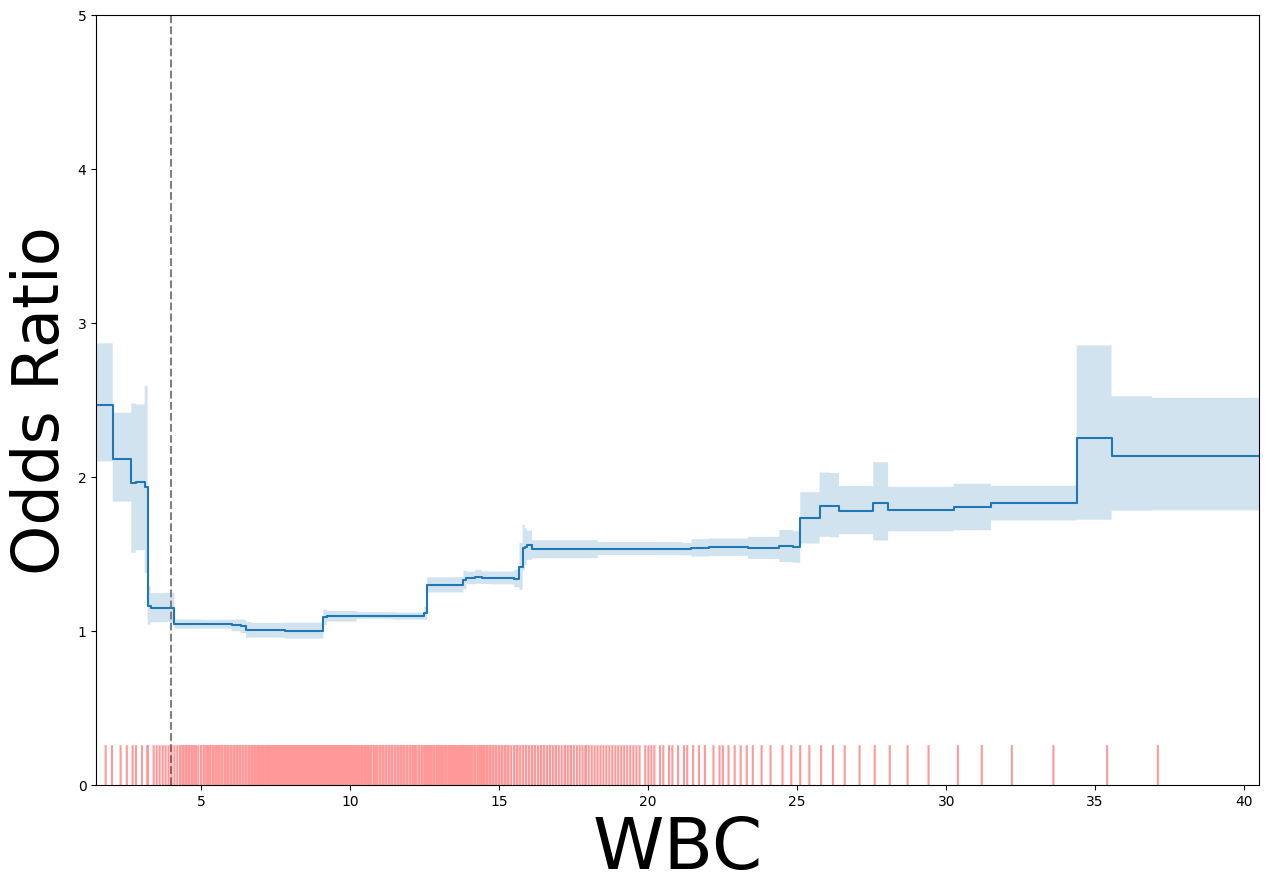

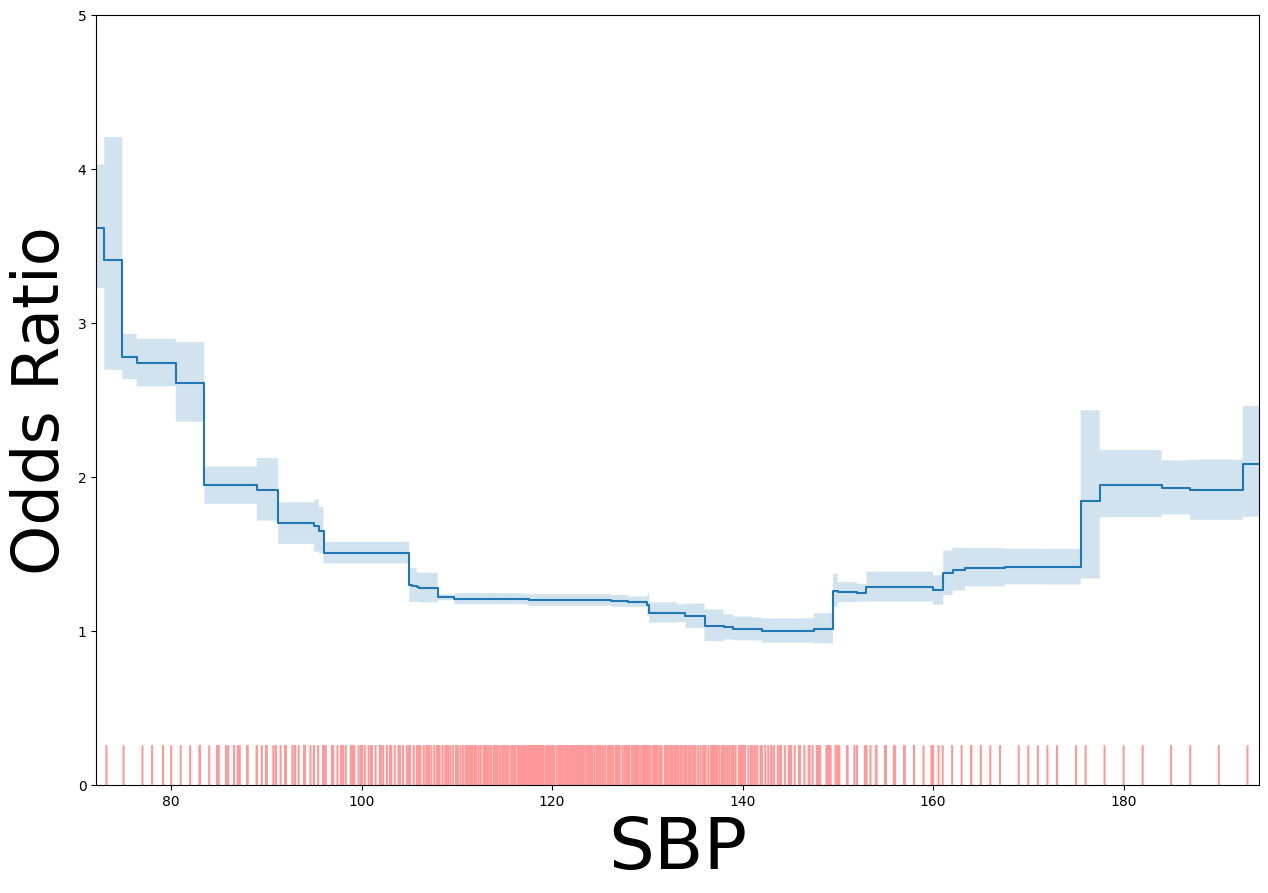

In [6]:
from ebm_utils.analysis.changepoints import find_and_plot_discontinuities, find_and_plot_non_monotonicities

find_and_plot_non_monotonicities(mimic2_X_sel, mimic2_Y.values,
                                 prob_threshold=0.1, counter_causal_only=True)

      Feature       Value # Samples  Effect Size             P-Ratio
3         Age   69.015167    2700.0     1.386645   882.5948193496708
18     Sodium  135.012484    3473.0     1.188837   600.7426042105001
11  HeartRate   84.984803    2304.0     1.293308   592.5964776183955
24        SBP  113.976359    2990.0     1.177954   489.6988340996675
26        SBP  129.999860    2123.0     1.127661   255.0696041620539
25        SBP  117.751933    3938.0     1.776174  2262.2292390836406
10  HeartRate   73.000162    4631.0     1.473360  1794.7231459696316
23        SBP   96.774427    2606.0     1.701068  1384.4537742992075
27        SBP  139.978749    2509.0     1.619171  1209.1224626410594
0         Age   47.308693    2701.0     1.557812  1197.3053153355513
1         Age   54.847076    2895.0     1.459020  1093.6290757522363
9   HeartRate   66.998788    2605.0     1.521413   1093.161767549869
(12, 5)


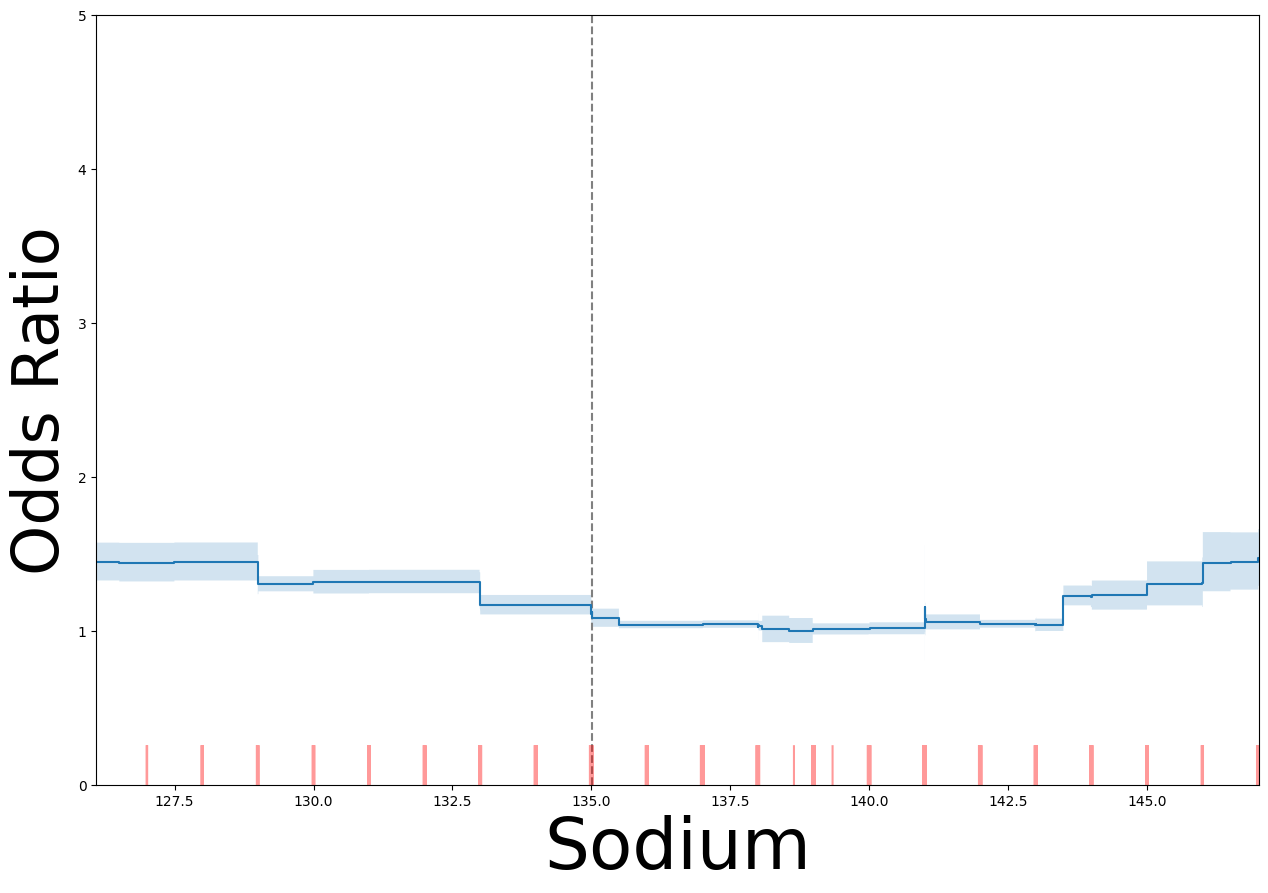

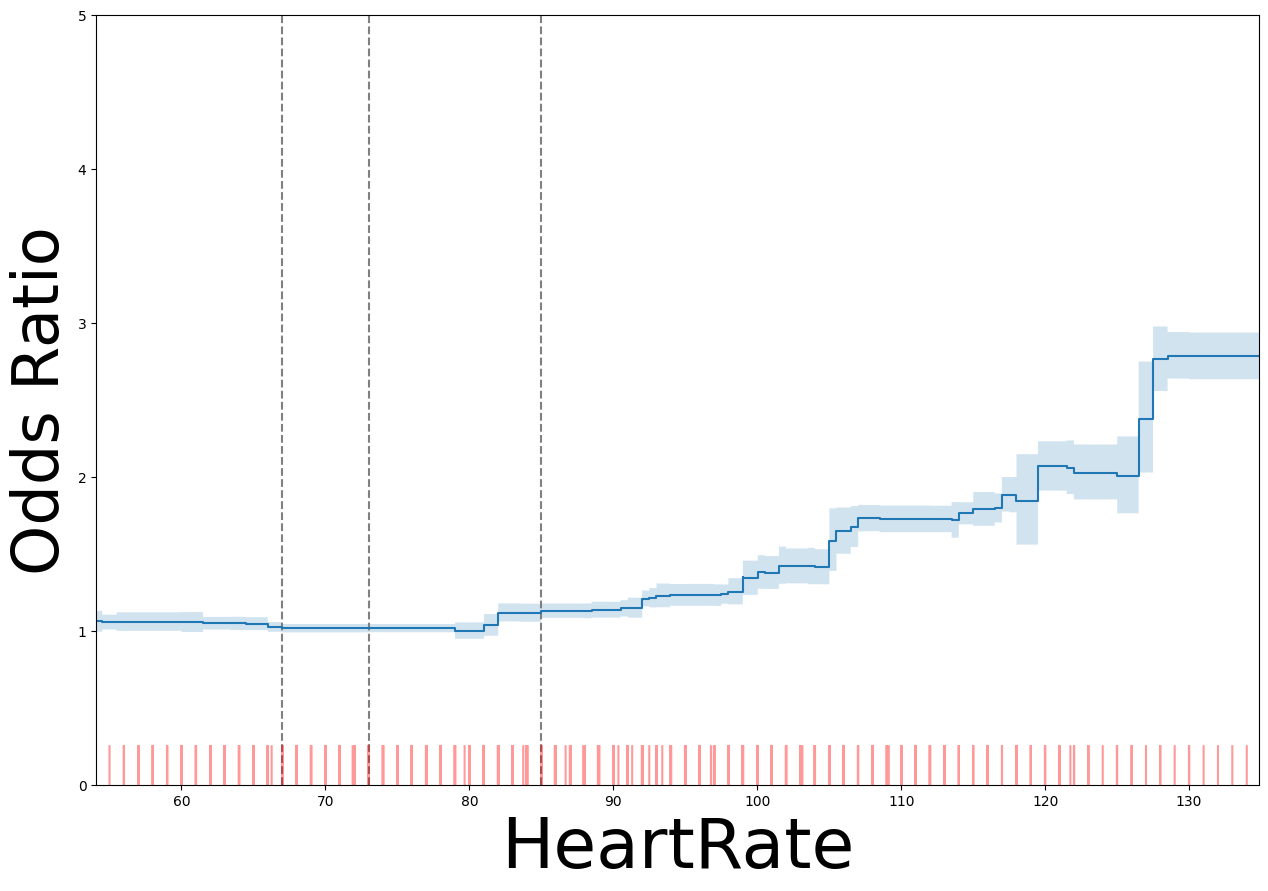

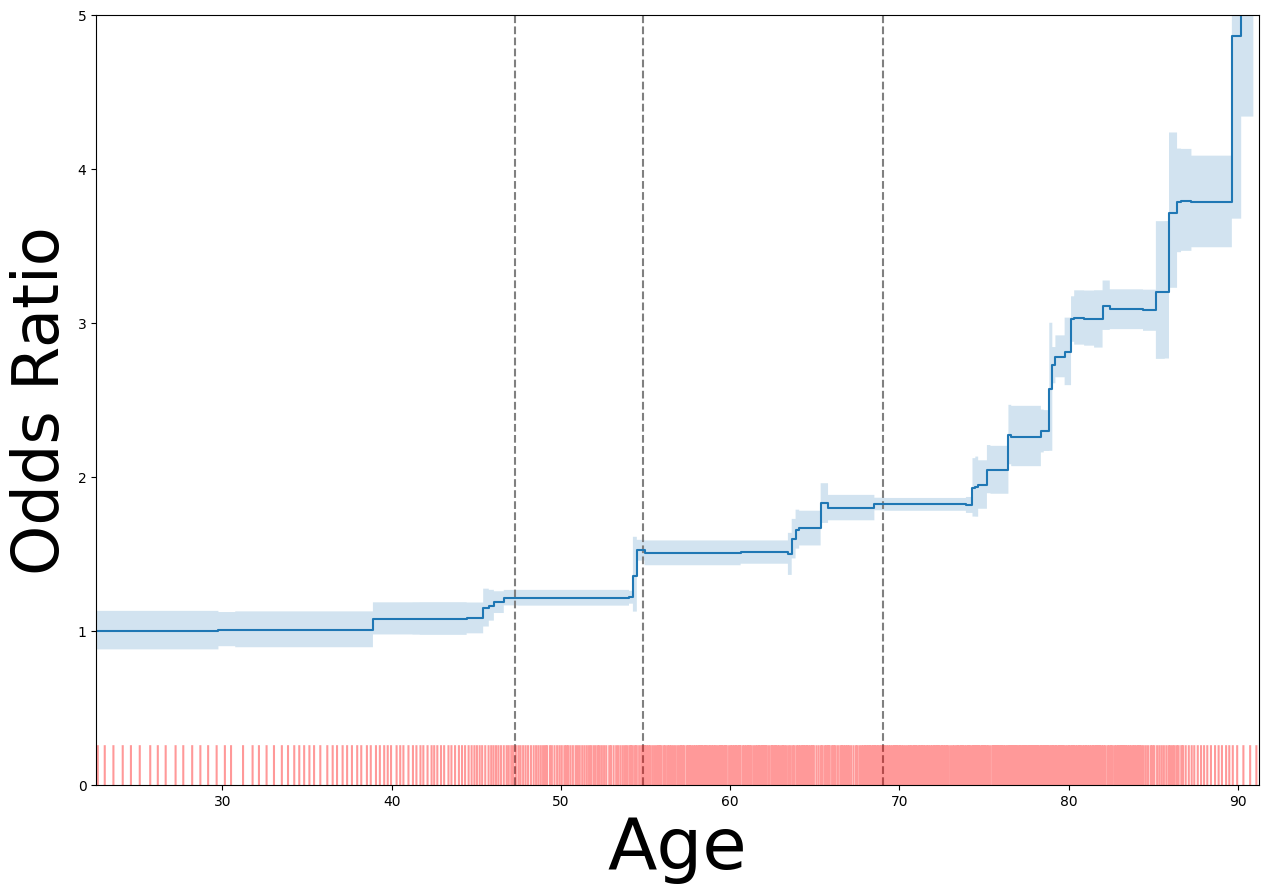

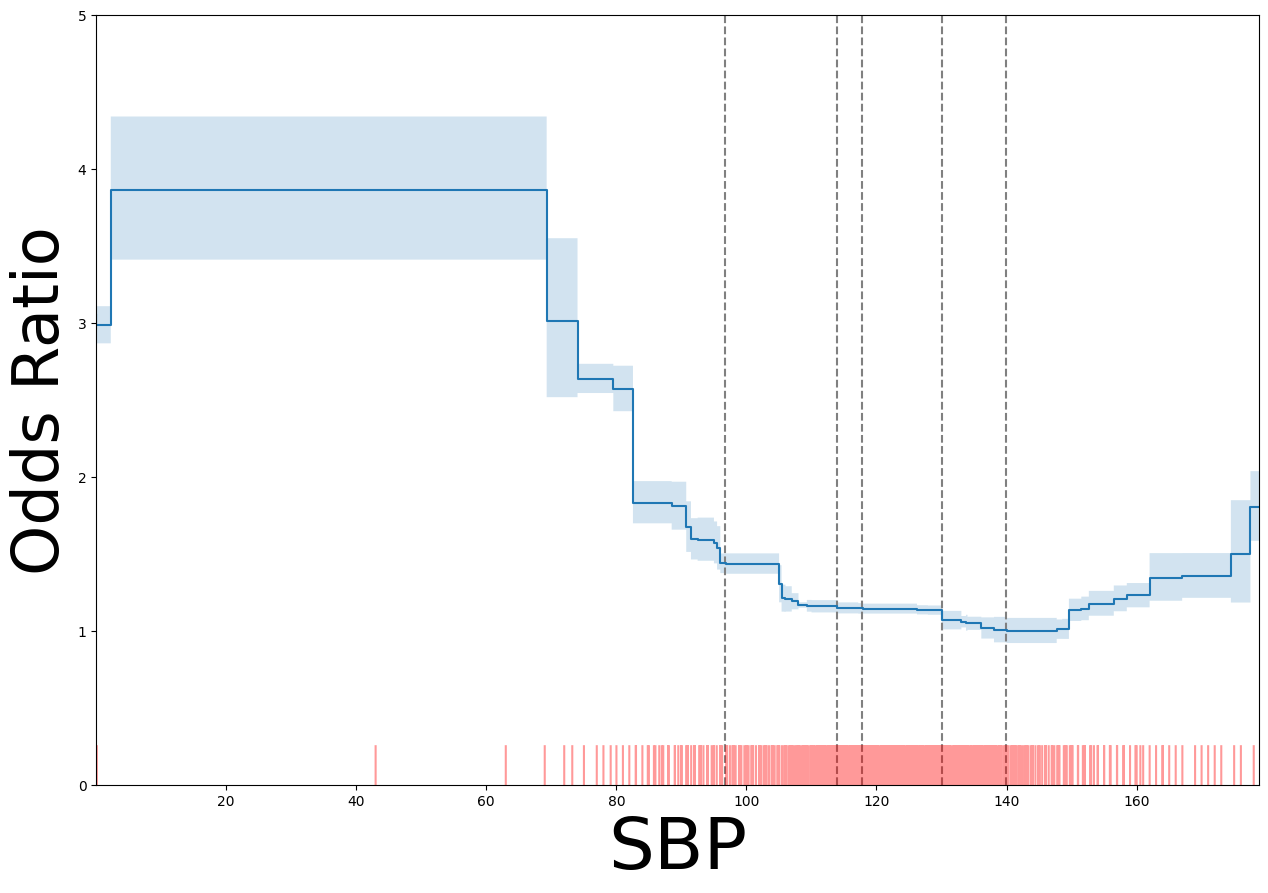

In [14]:
disc = find_and_plot_discontinuities(
    mimic2_X_sel, mimic2_Y.values,
    min_samples=2000,
    min_effect_size=1.1)
print(disc)
print(disc.shape)

In [5]:
ebms["mimic3"], ebm_globals["mimic3"] = run_experiment(mimic3_X_sel, mimic3_Y)

XGB-1
AUC	Train:0.77
AUC	Test:0.74
APS	Train:0.32
APS	Test:0.26
F1	Train:0.11
F1	Test:0.08
XGB-2
AUC	Train:0.89
AUC	Test:0.74
APS	Train:0.63
APS	Test:0.25
F1	Train:0.37
F1	Test:0.17
XGB-3
AUC	Train:0.98
AUC	Test:0.70
APS	Train:0.92
APS	Test:0.23
F1	Train:0.75
F1	Test:0.17
MLP
AUC	Train:0.66
AUC	Test:0.65
APS	Train:0.21
APS	Test:0.21
F1	Train:0.02
F1	Test:0.03
EBM
AUC	Train:0.76
AUC	Test:0.74
APS	Train:0.30
APS	Test:0.26
F1	Train:0.06
F1	Test:0.07
Calibrated EBM
AUC	Train:0.76
AUC	Test:0.76
APS	Train:0.29
APS	Test:0.30
F1	Train:0.07
F1	Test:0.09


,Feature,Value
0,Glucose,72.000000
1,Glucose,324.000000
2,Temp,35.666665
3,WBC,0.900000


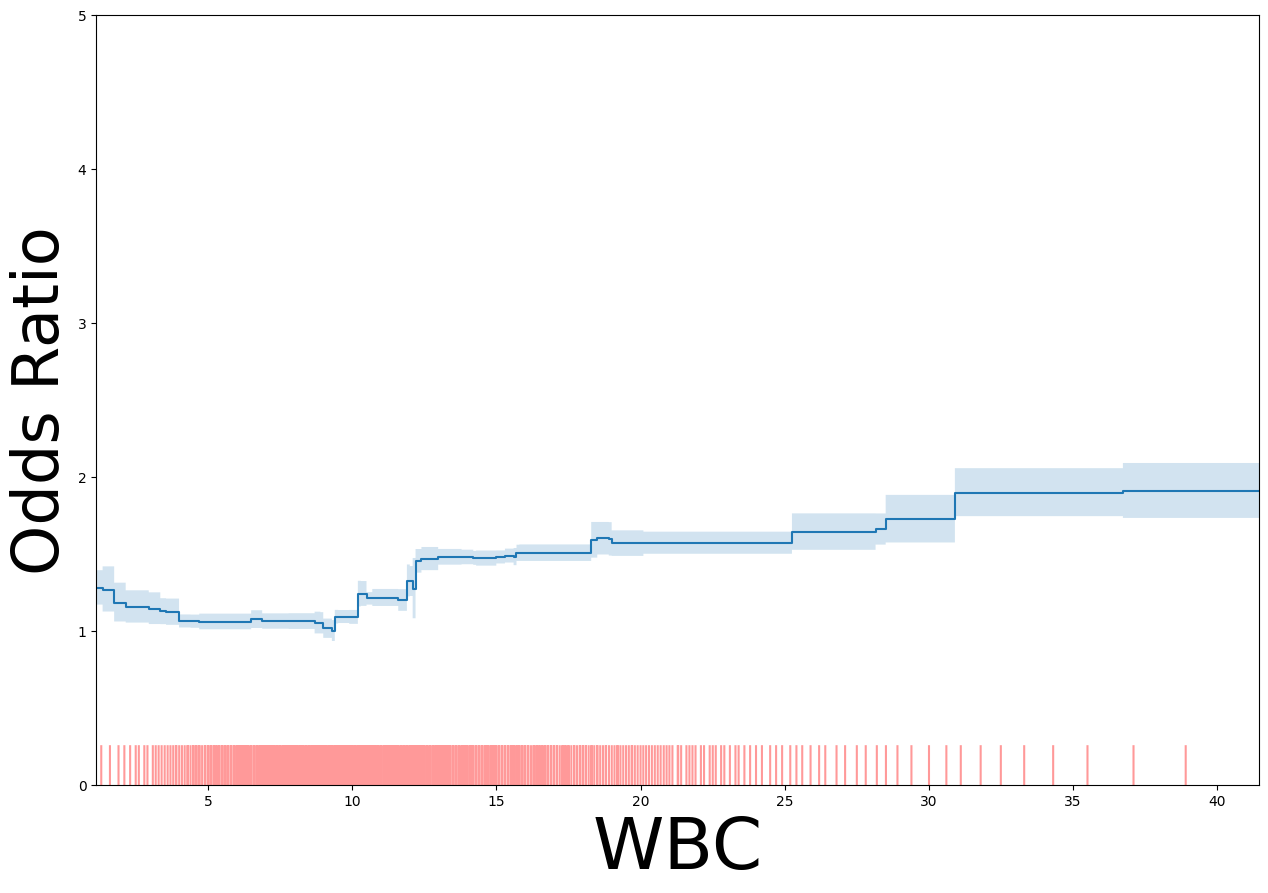

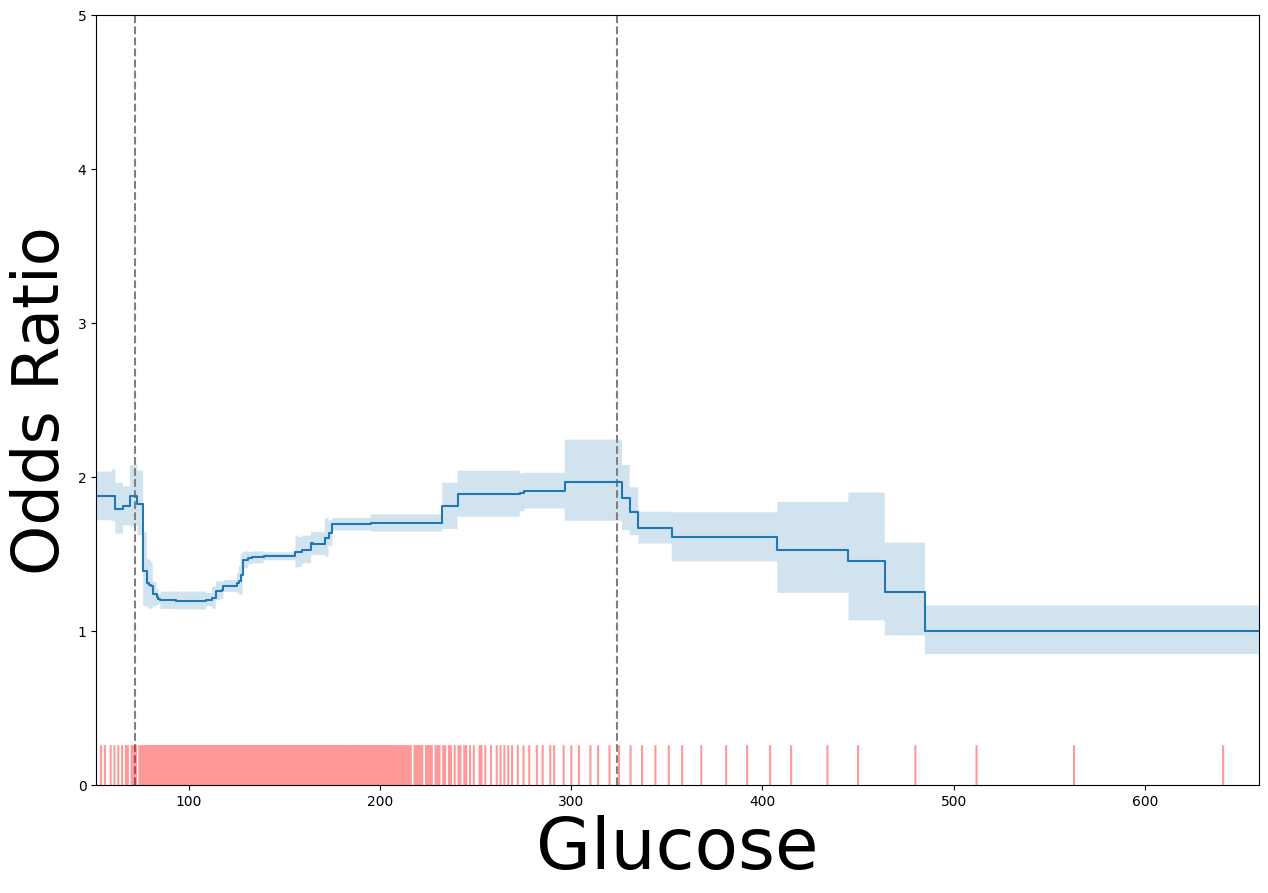

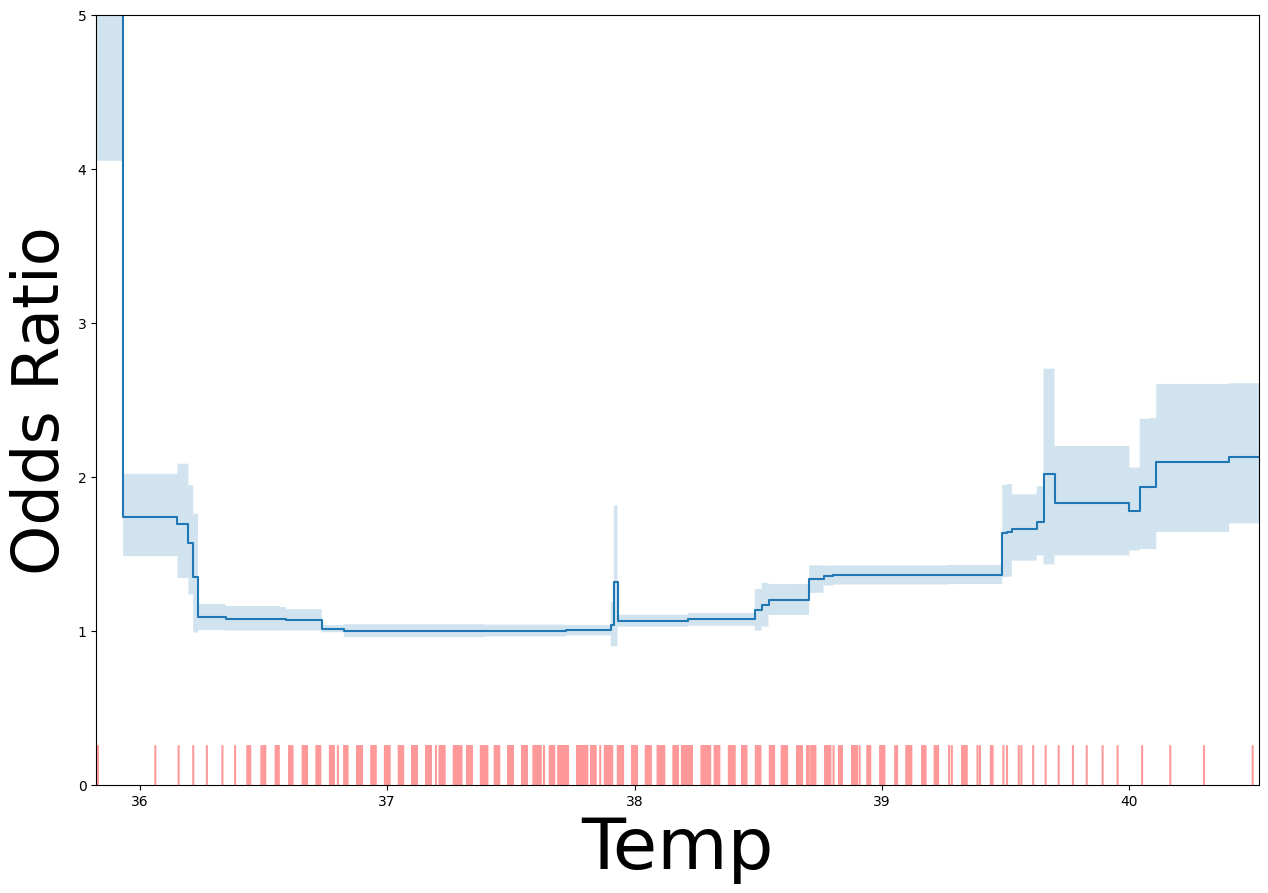

In [8]:
find_and_plot_non_monotonicities(mimic3_X_sel, mimic3_Y,
                                 prob_threshold=0.1, counter_causal_only=True)

      Feature       Value # Samples  Effect Size             P-Ratio
14        BUN   18.005683    4391.0     1.249248    977.180544273025
63        SBP  142.994720    2907.0     1.386146   949.2154774574595
29    Glucose   84.016098    6361.0     4.269945    9233.63413326177
50   Platelet  455.992518    2160.0    69.361806   9156.966567802756
45   Platelet  211.990089    4286.0     6.917734   8289.502172384913
30    Glucose  117.997057    2039.0     1.470283   785.9426110838964
59     Sodium  129.999948    3132.0     1.266494   739.9428576520957
31    Glucose  138.004446    2469.0     1.346155   733.9161507776329
46   Platelet  247.643320    5259.0     1.136828   674.4252427365323
60     Sodium  134.007890    4092.0     1.159506   605.5918723508765
37  HeartRate   99.990000    2261.0     1.296796   587.6254144094363
12        BUN   12.003176    3447.0     1.166911   532.0798772149368
71        WBC    6.987966    4416.0     1.117916   492.2337974800352
13        BUN   14.008690    4737.

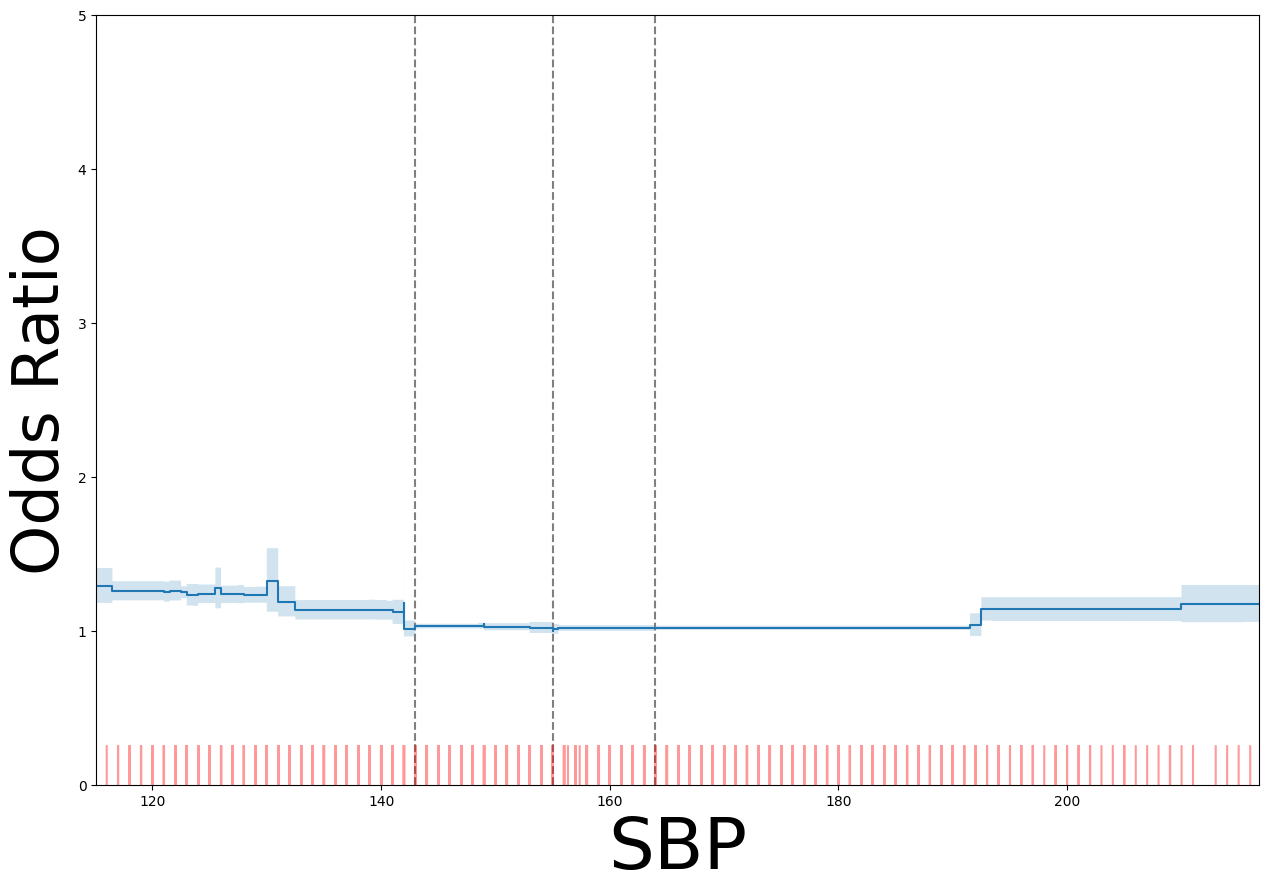

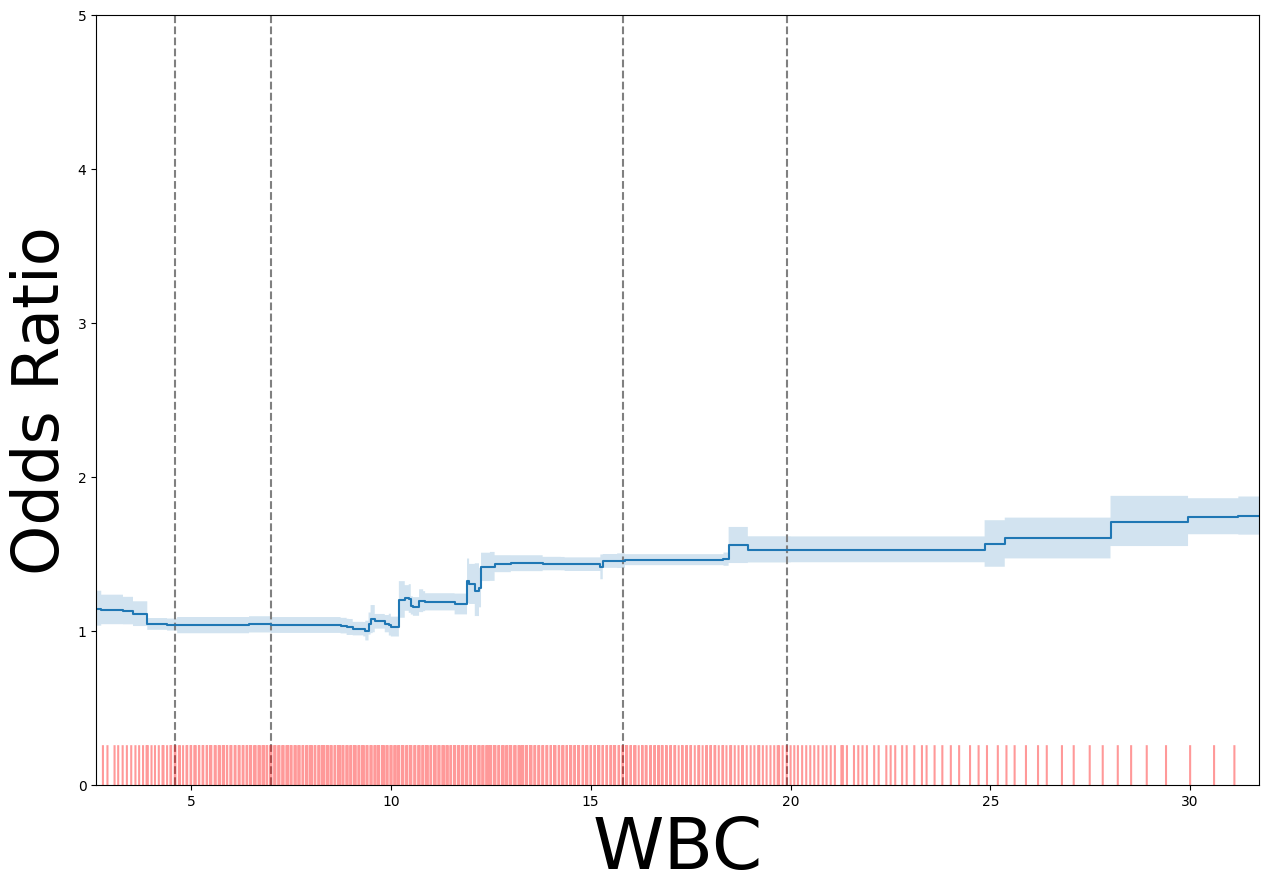

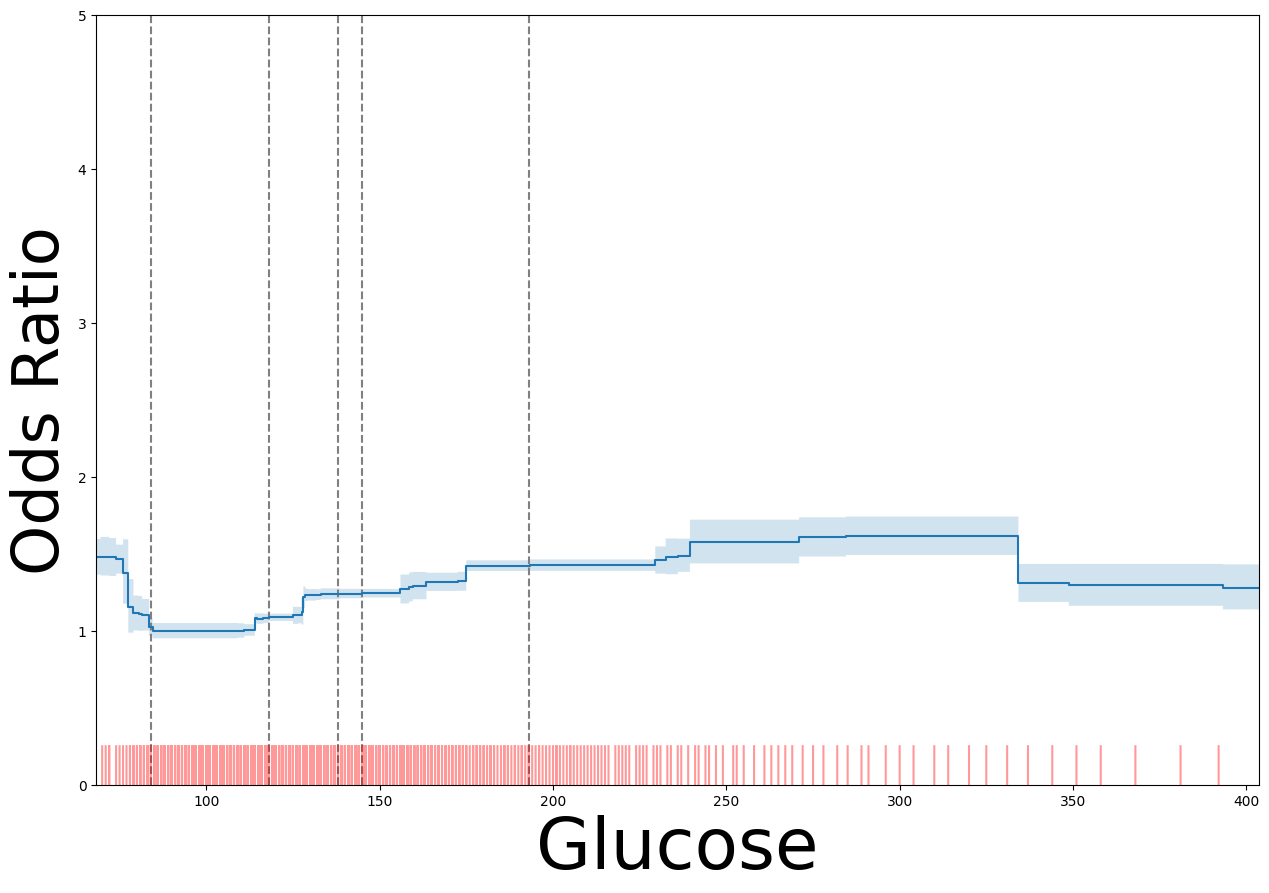

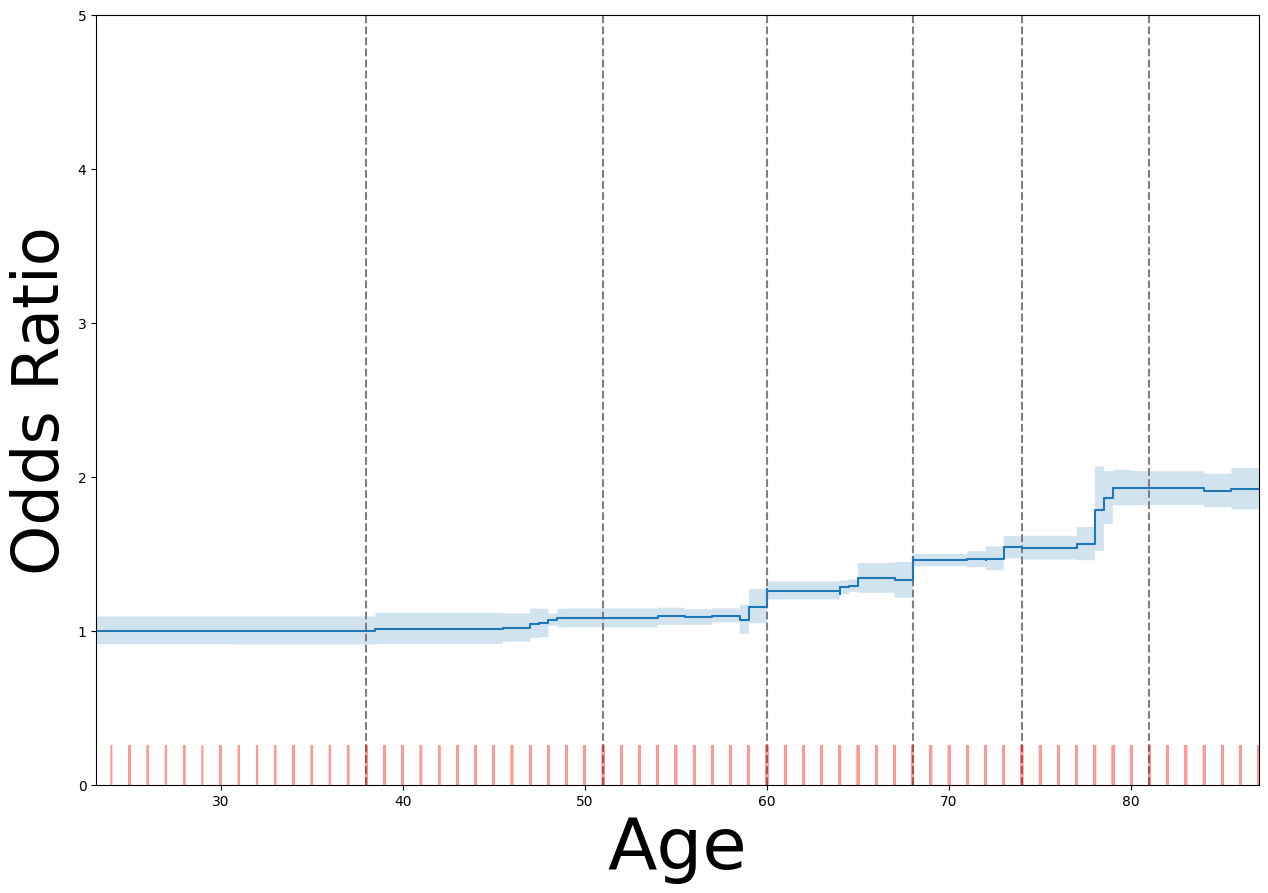

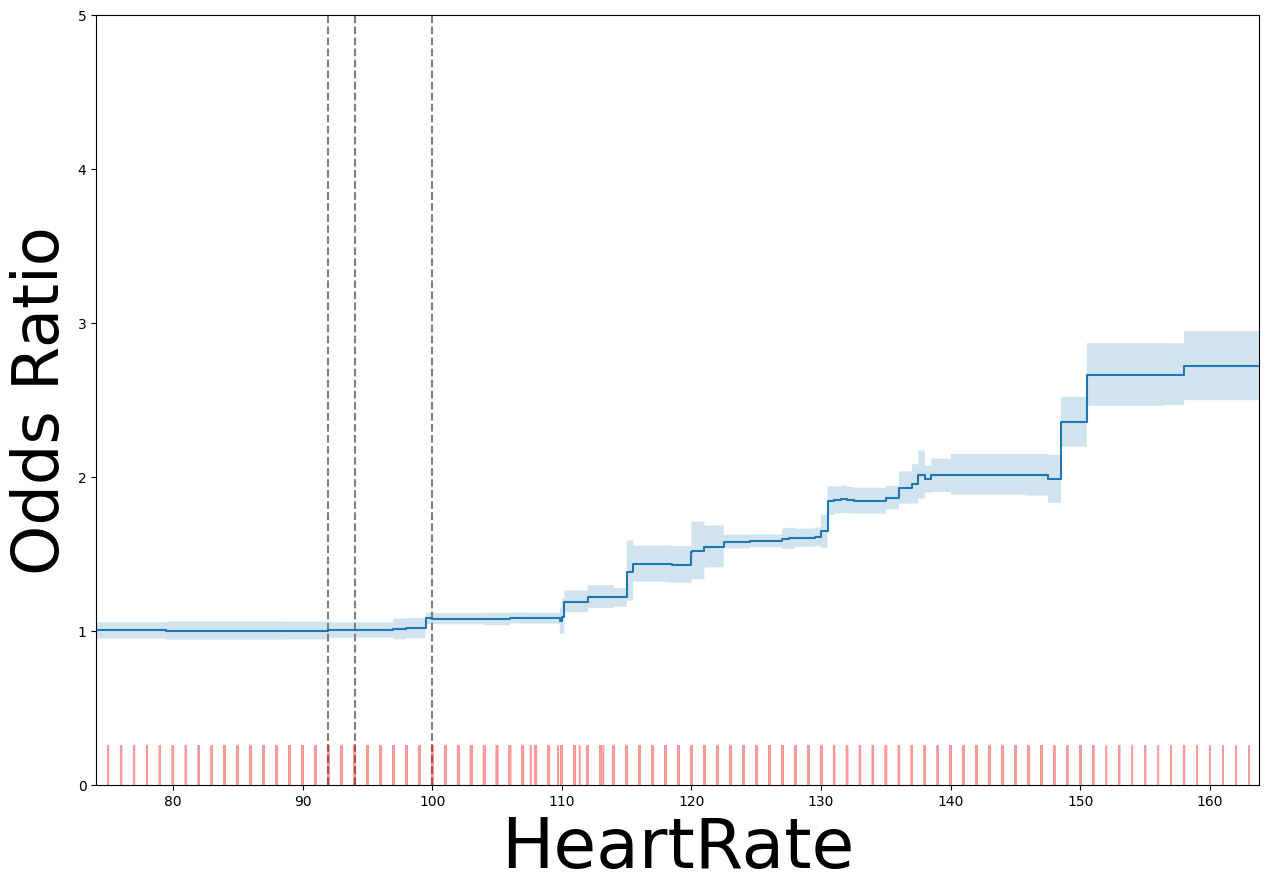

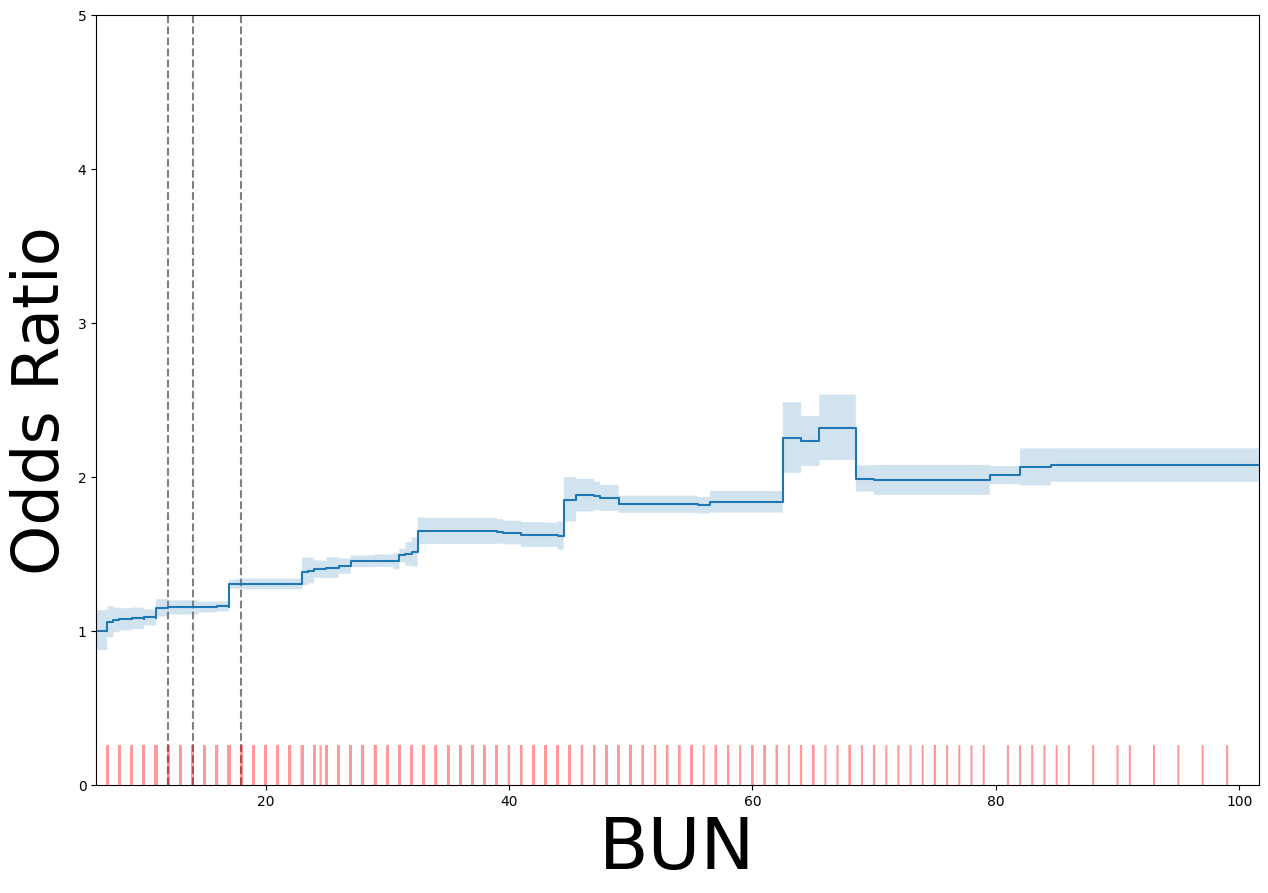

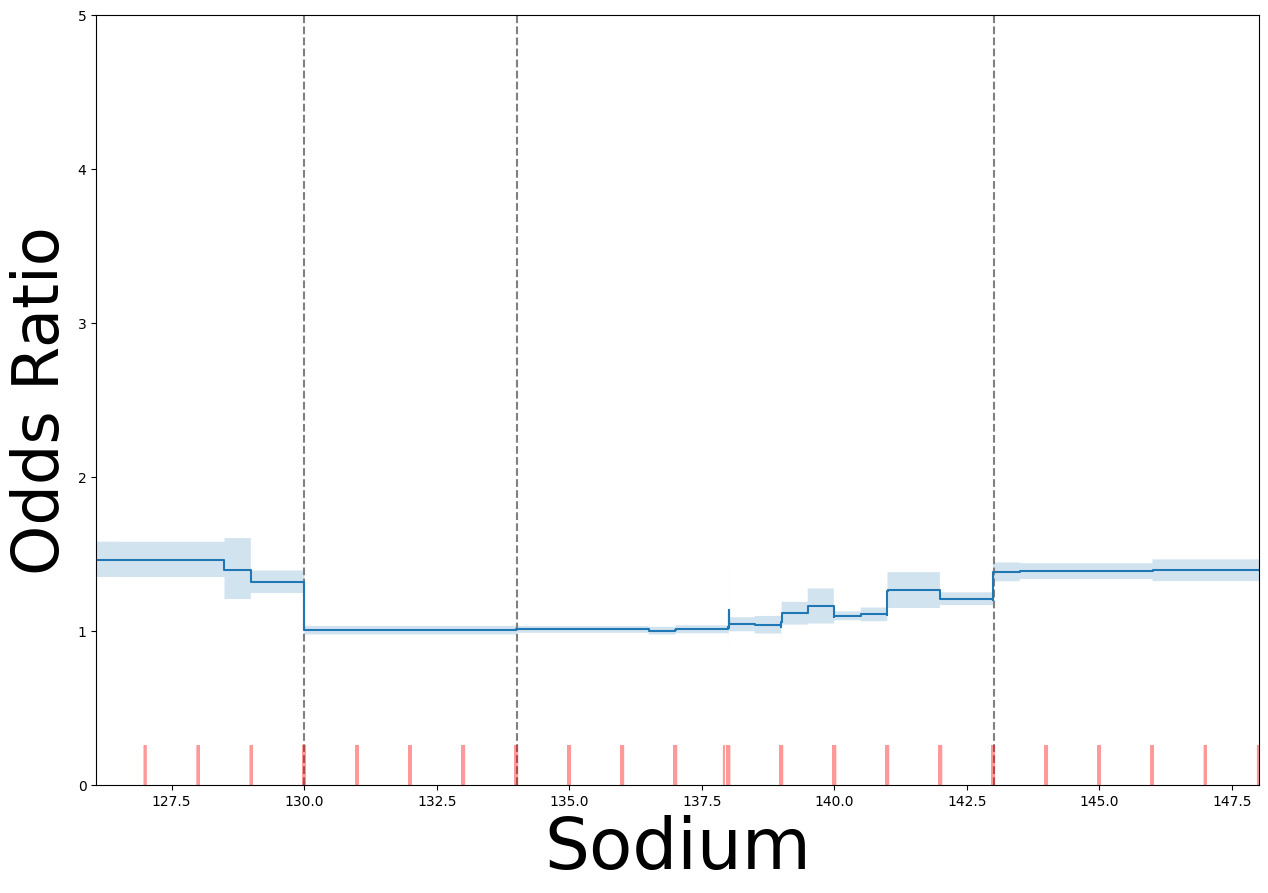

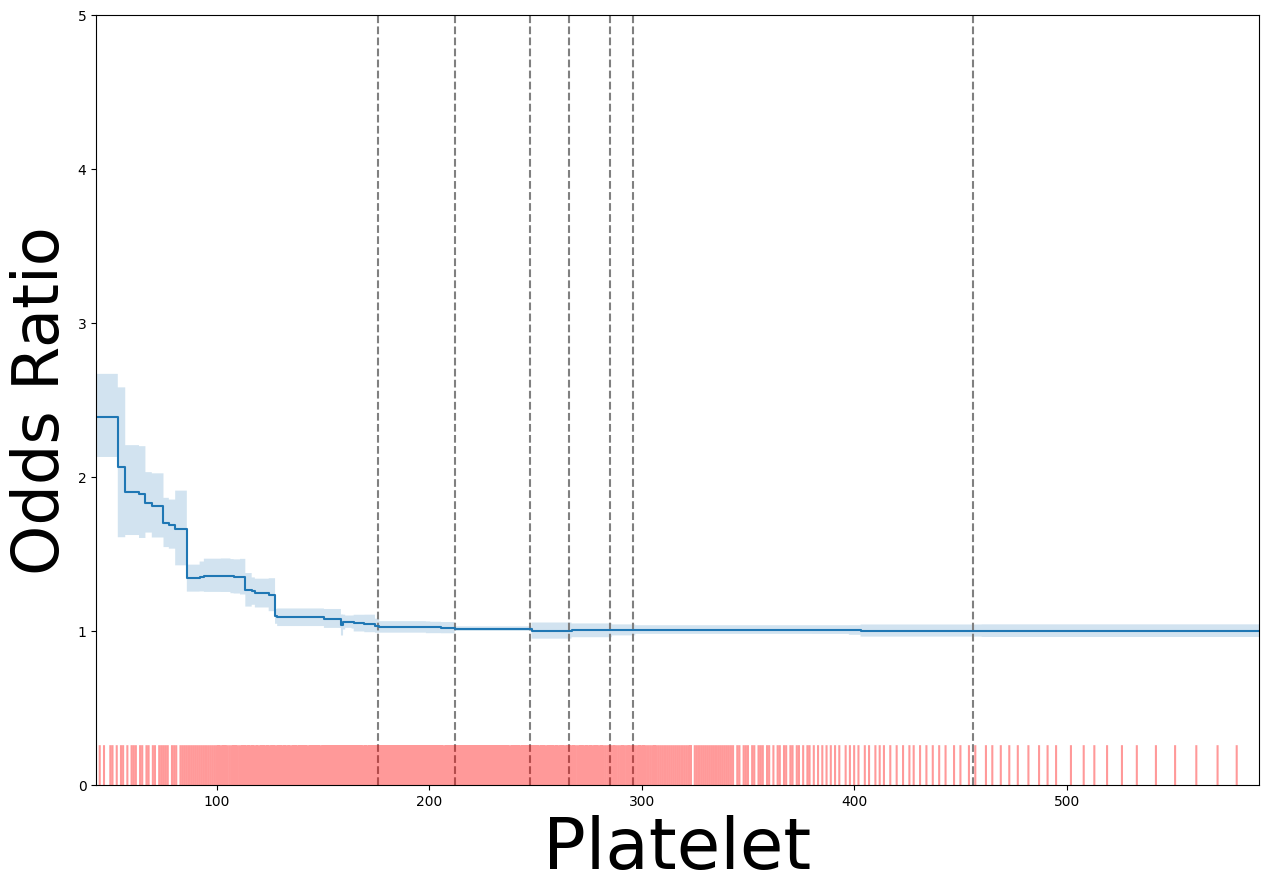

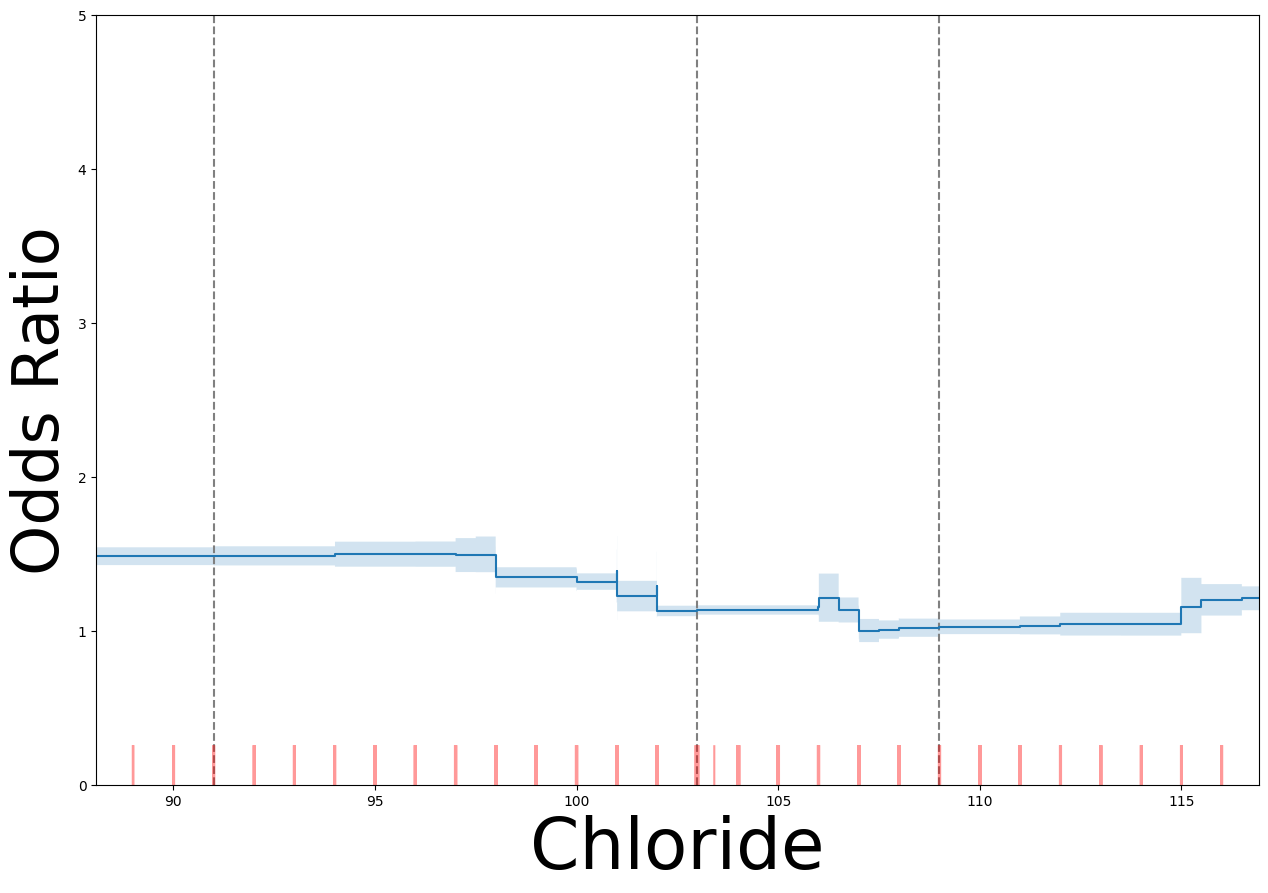

In [15]:
disc = find_and_plot_discontinuities(mimic3_X_sel, mimic3_Y,
                                                min_samples=2000,
                                                min_effect_size=1.1)
print(disc)
print(disc.shape)

In [6]:
ebms["mimic4"], ebm_globals["mimic4"] = run_experiment(mimic4_X_sel, mimic4_Y)

XGB-1
AUC	Train:0.75
AUC	Test:0.74
APS	Train:0.25
APS	Test:0.24
F1	Train:0.10
F1	Test:0.10
XGB-2
AUC	Train:0.81
AUC	Test:0.75
APS	Train:0.42
APS	Test:0.27
F1	Train:0.29
F1	Test:0.17
XGB-3
AUC	Train:0.85
AUC	Test:0.73
APS	Train:0.56
APS	Test:0.25
F1	Train:0.48
F1	Test:0.20
MLP
AUC	Train:0.73
AUC	Test:0.73
APS	Train:0.26
APS	Test:0.25
F1	Train:0.14
F1	Test:0.13
EBM
AUC	Train:0.75
AUC	Test:0.74
APS	Train:0.25
APS	Test:0.24
F1	Train:0.08
F1	Test:0.07
Calibrated EBM
AUC	Train:0.75
AUC	Test:0.75
APS	Train:0.25
APS	Test:0.26
F1	Train:0.08
F1	Test:0.08


,Feature,Value
0,SBP,81.0
1,Chloride,115.0
2,Creatinine,3.5
3,Magnesium,2.6
4,Platelet,16.0
5,Potassium,6.7
6,Temp,35.0


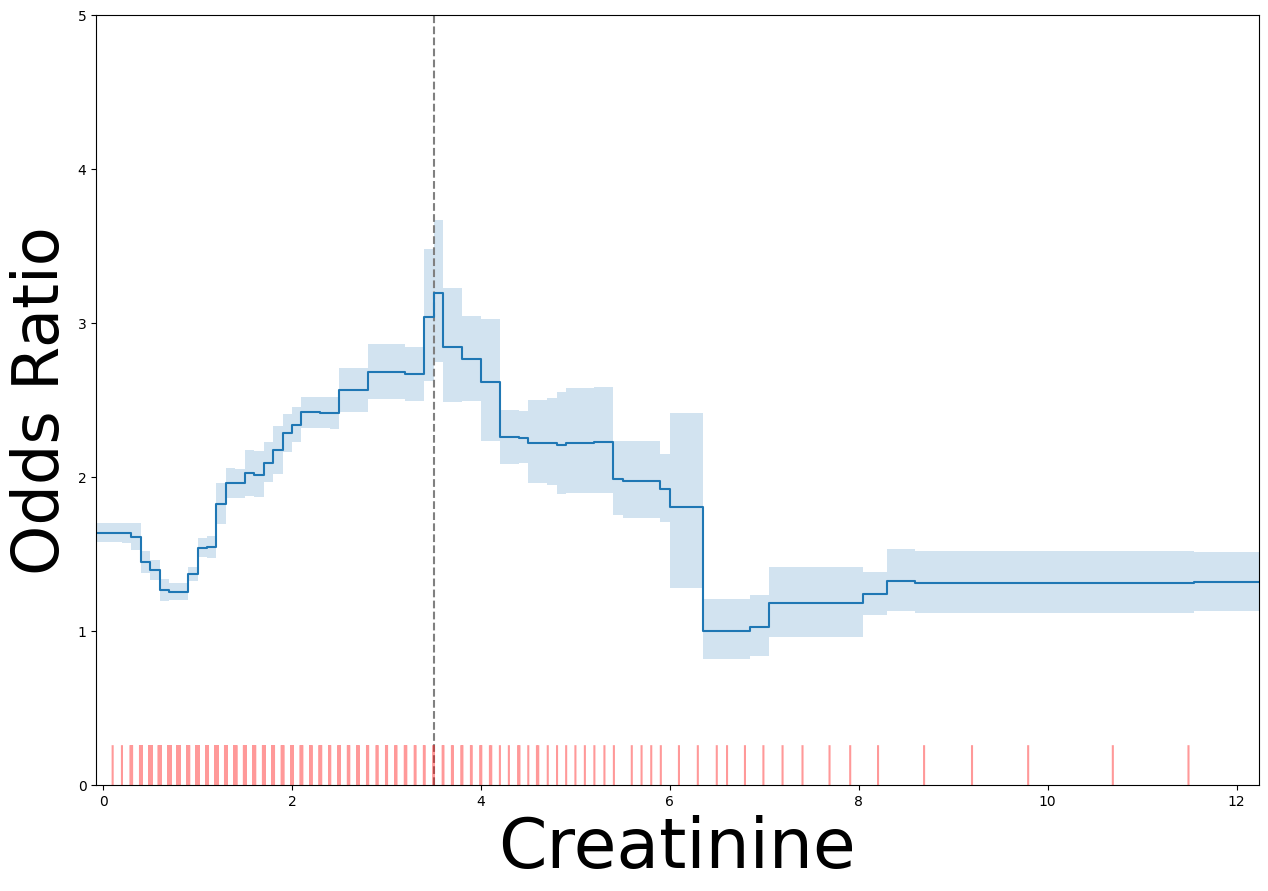

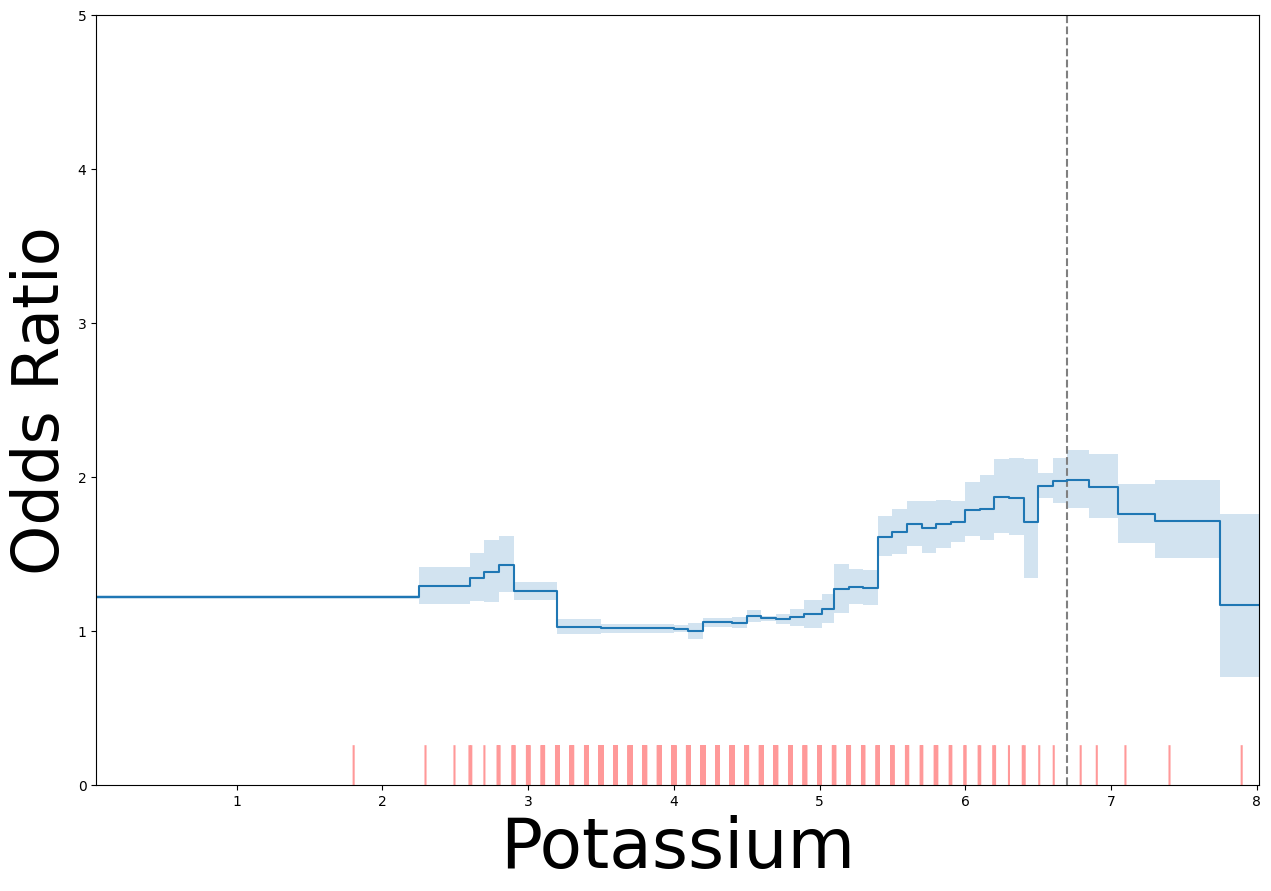

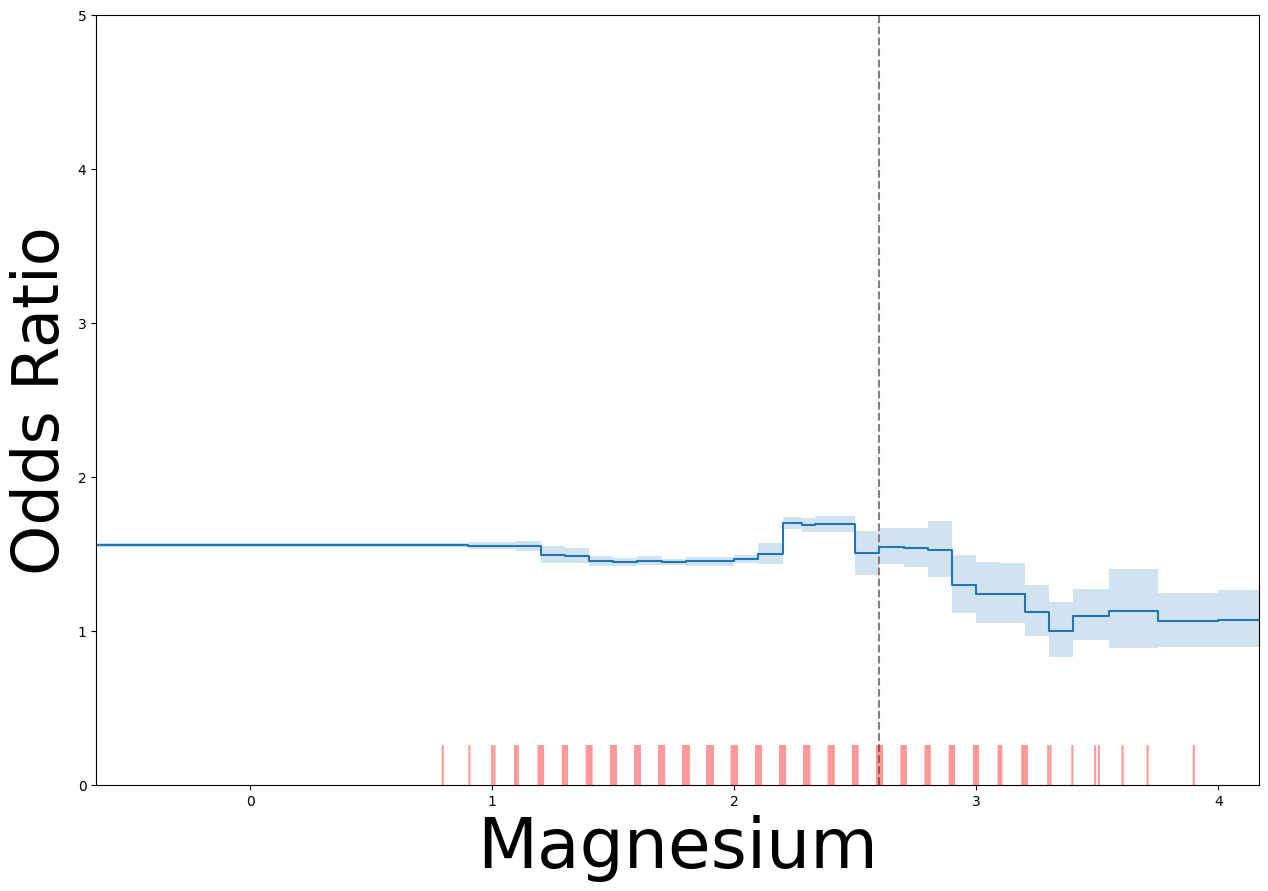

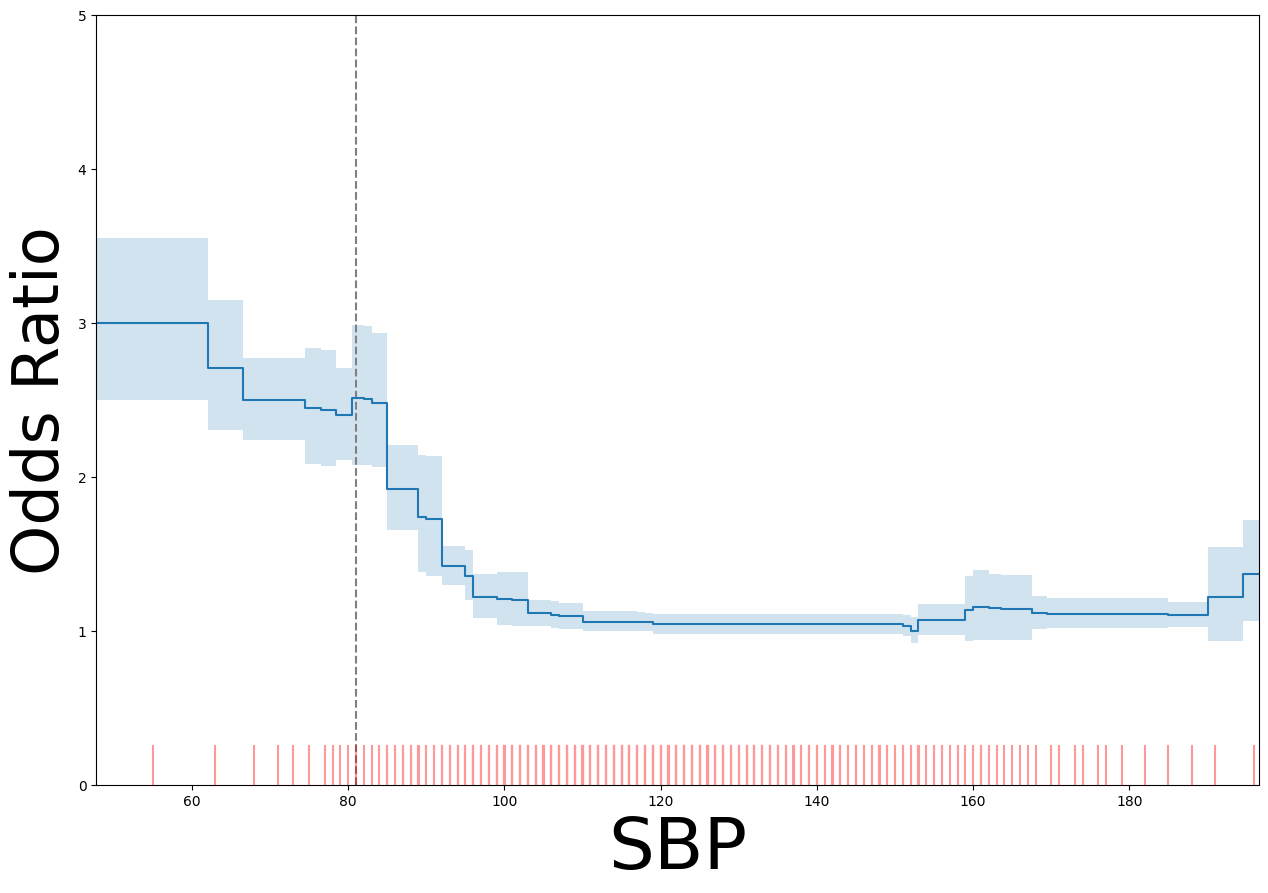

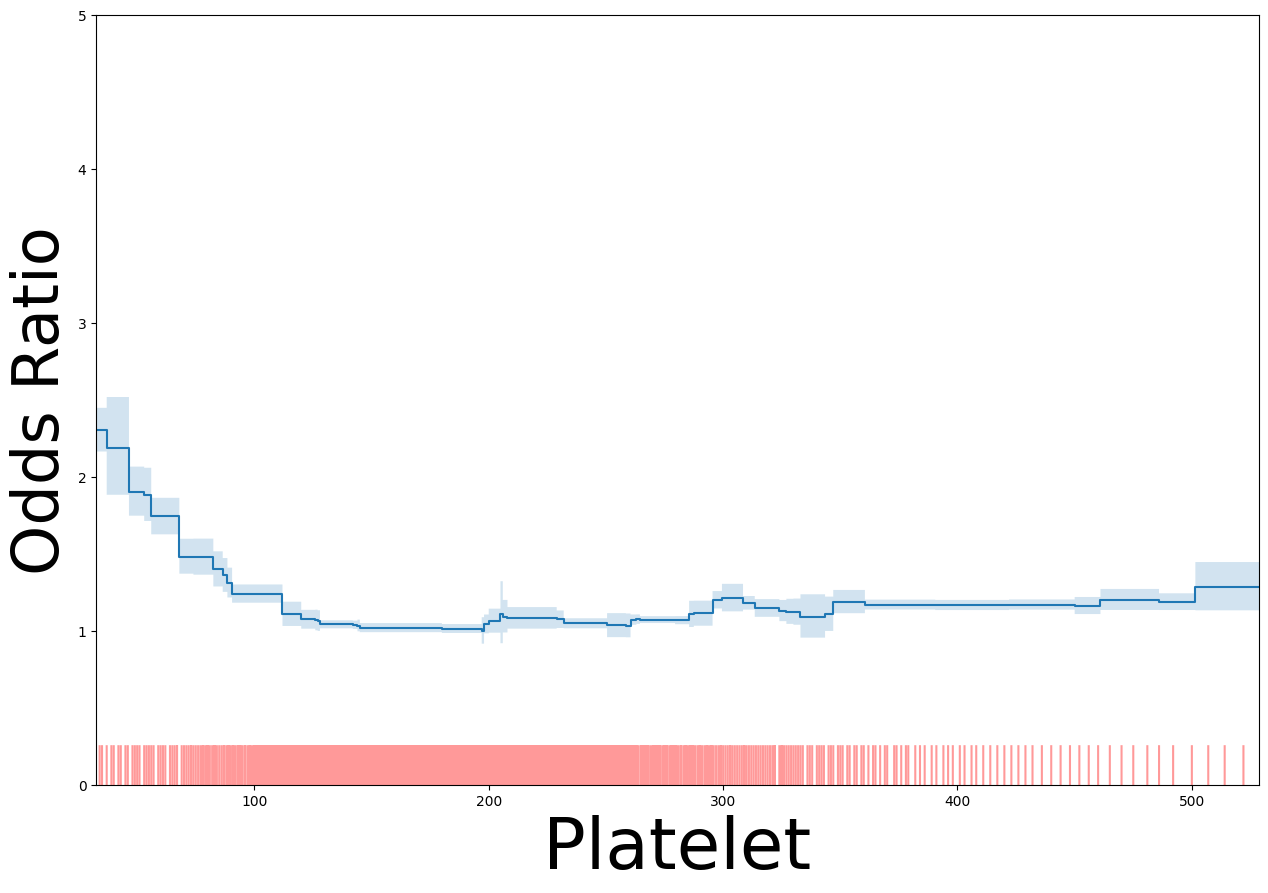

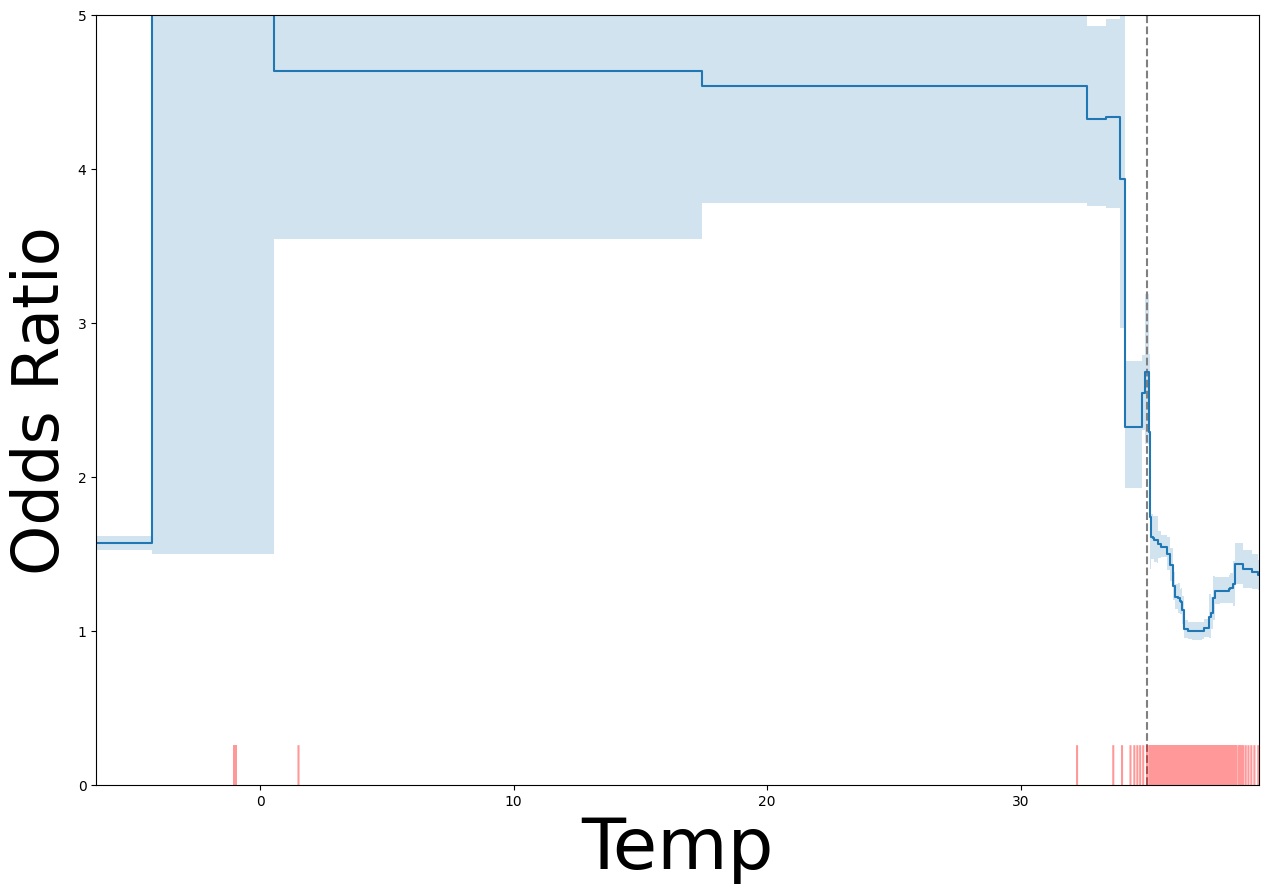

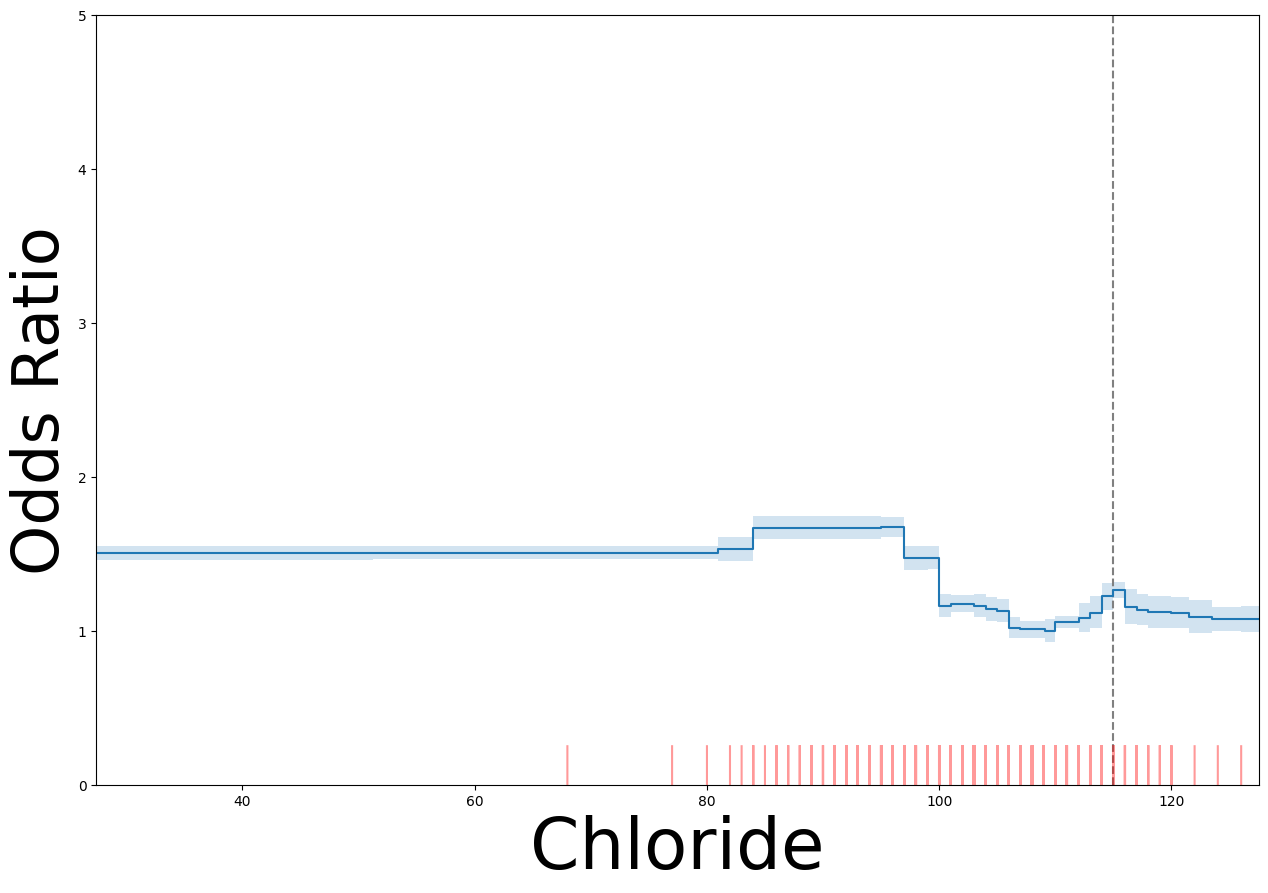

In [7]:
find_and_plot_non_monotonicities(mimic4_X_sel, mimic4_Y.values,
                                 prob_threshold=0.1, counter_causal_only=True)

,Feature,Value,# Samples,Effect Size,P-Ratio
82,Glucose,106.000000,5268.0,1.205830,986.0
81,Glucose,99.000000,7978.0,1.111032,840.0
5,Age,50.000000,4503.0,1.199735,820.0
25,Age,78.000000,5824.0,1.146653,797.0
84,Glucose,122.000000,3851.0,1.182639,646.0
32,Age,90.000000,3702.0,1.188723,640.0
47,SBP,109.990749,2410.0,1.277495,590.2115850195291
87,Glucose,174.000000,2192.0,1.273525,530.0
83,Glucose,117.000000,2396.0,1.240307,516.0
121,Platelet,273.007384,2109.0,1.262697,491.92406947326845


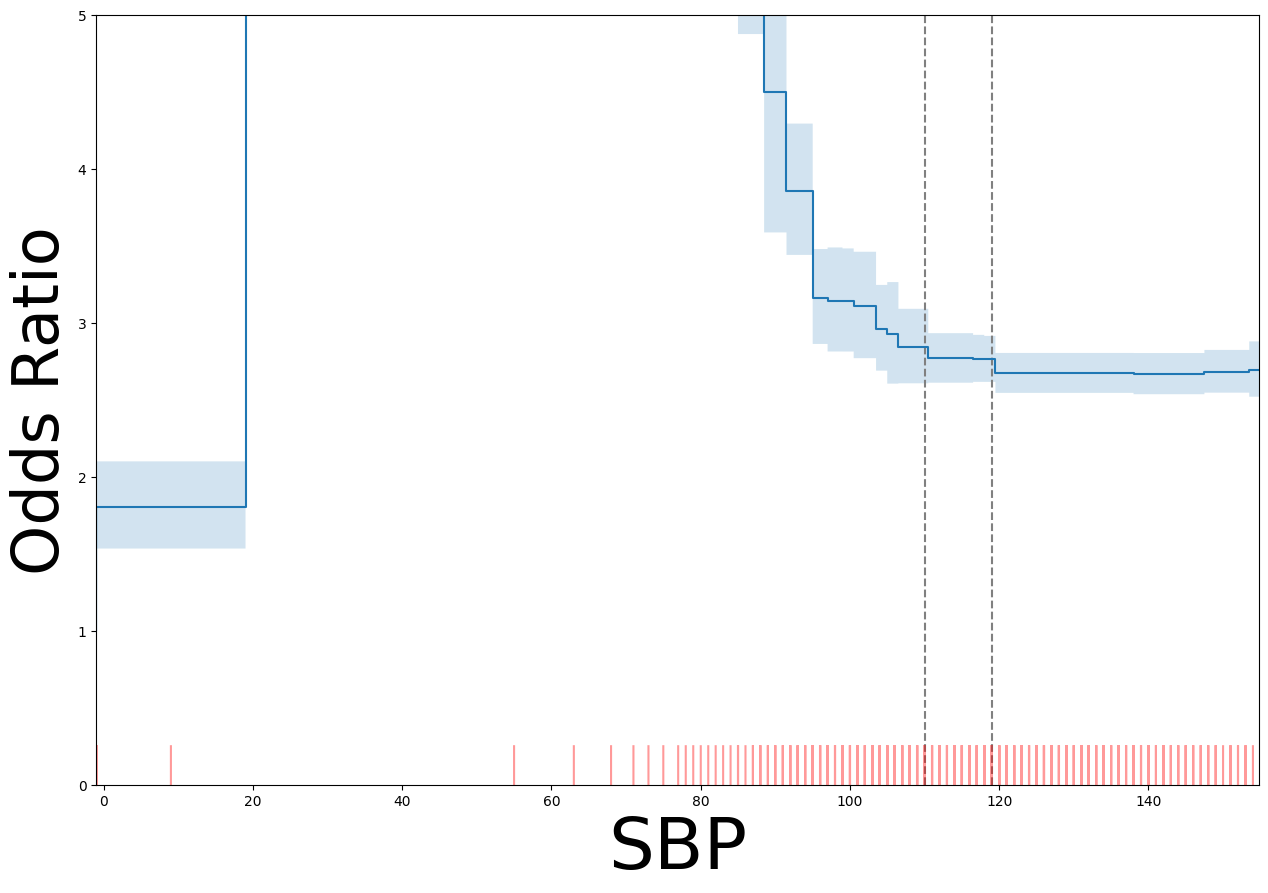

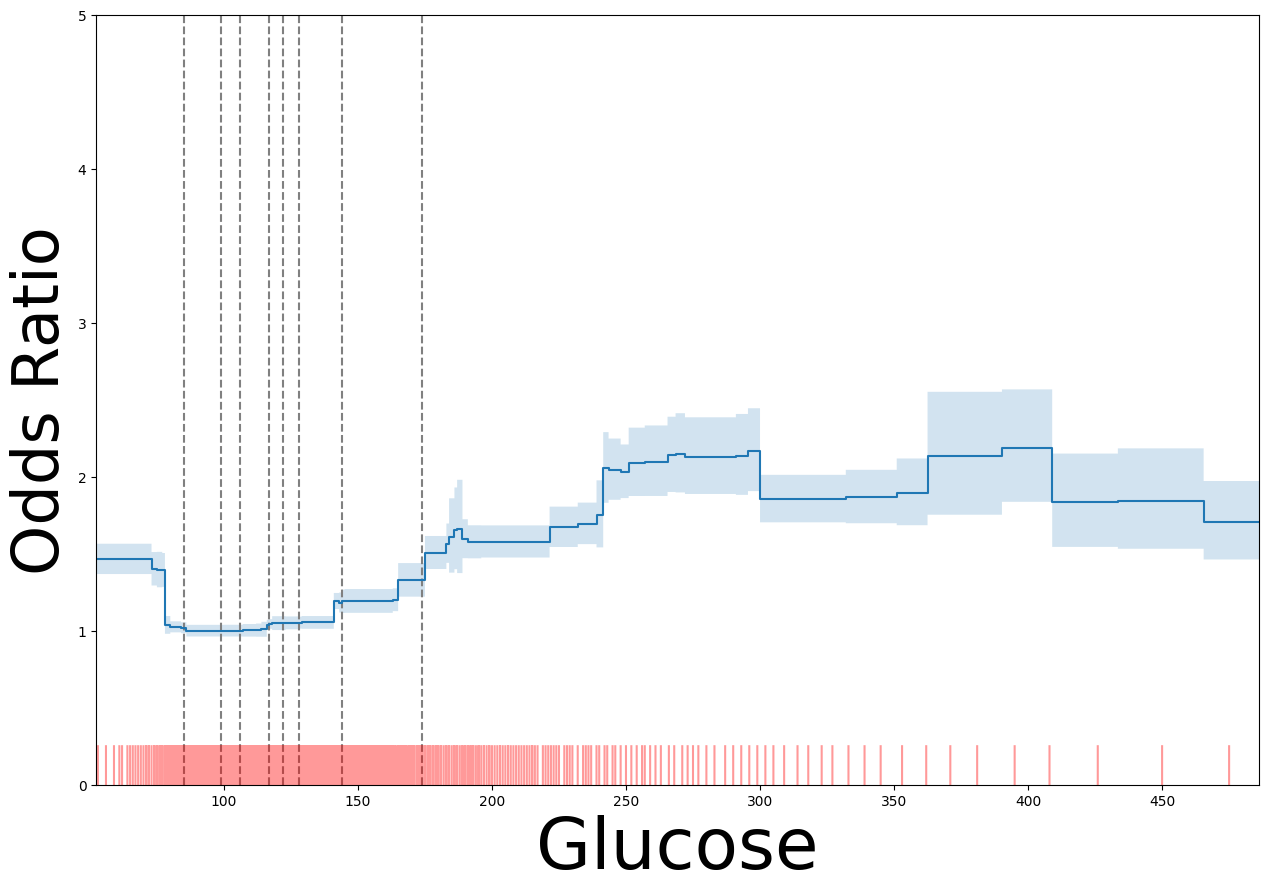

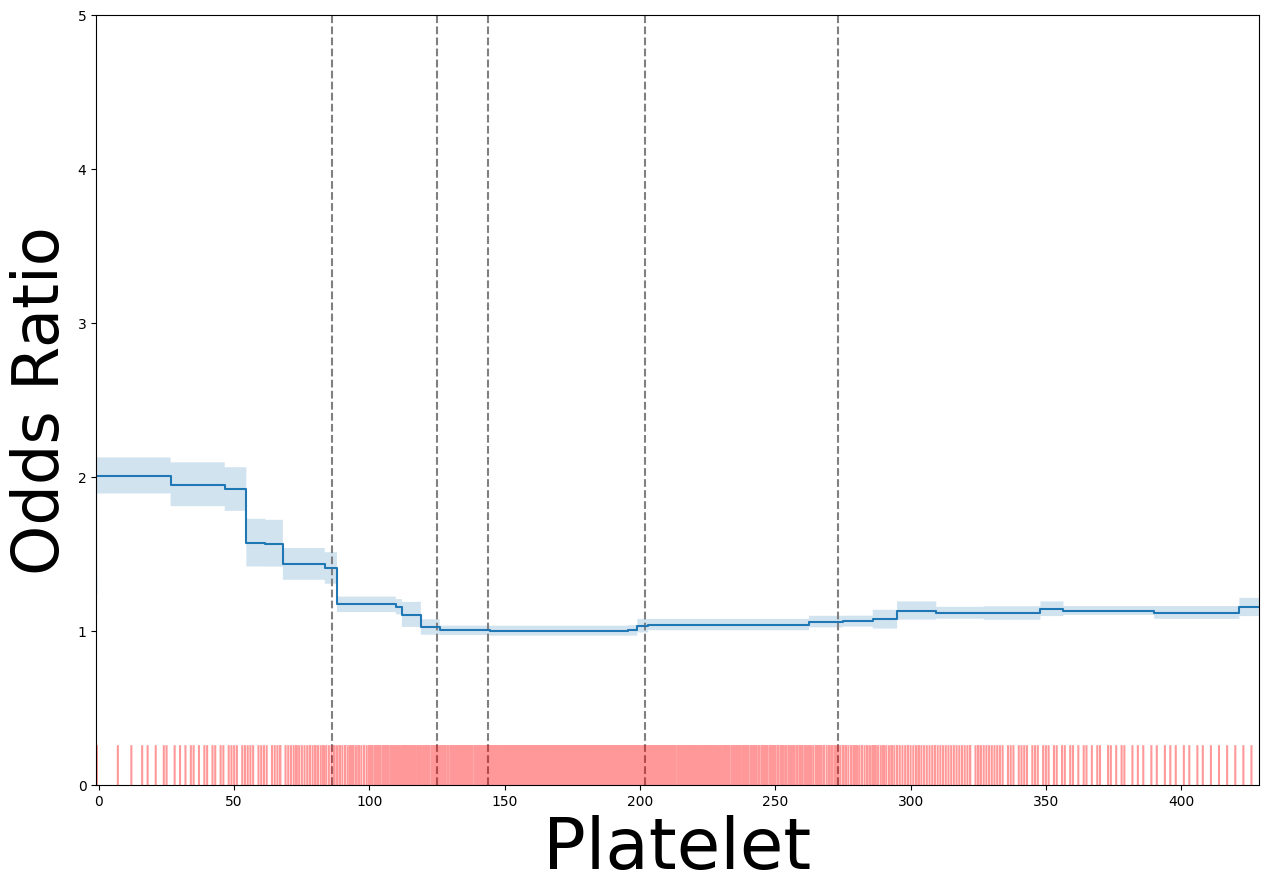

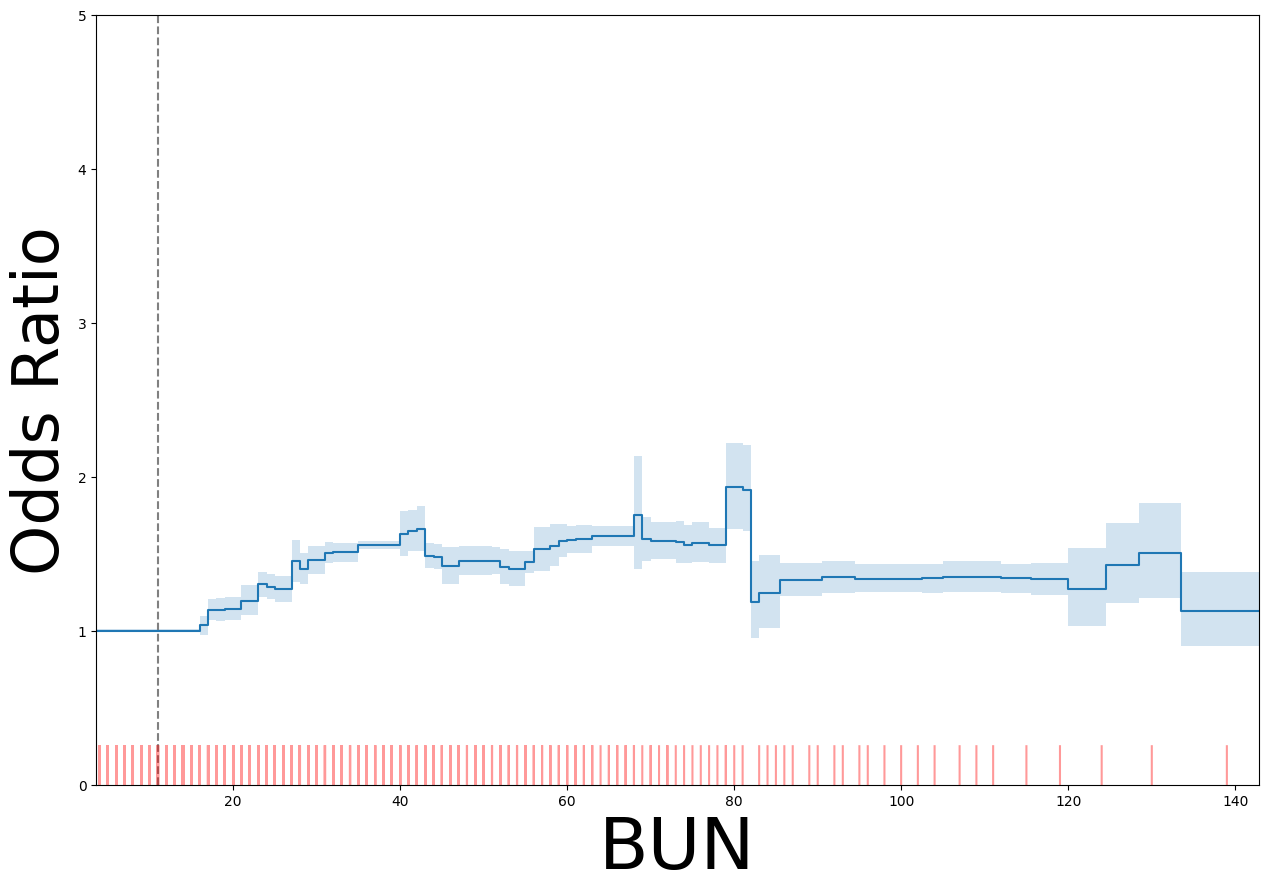

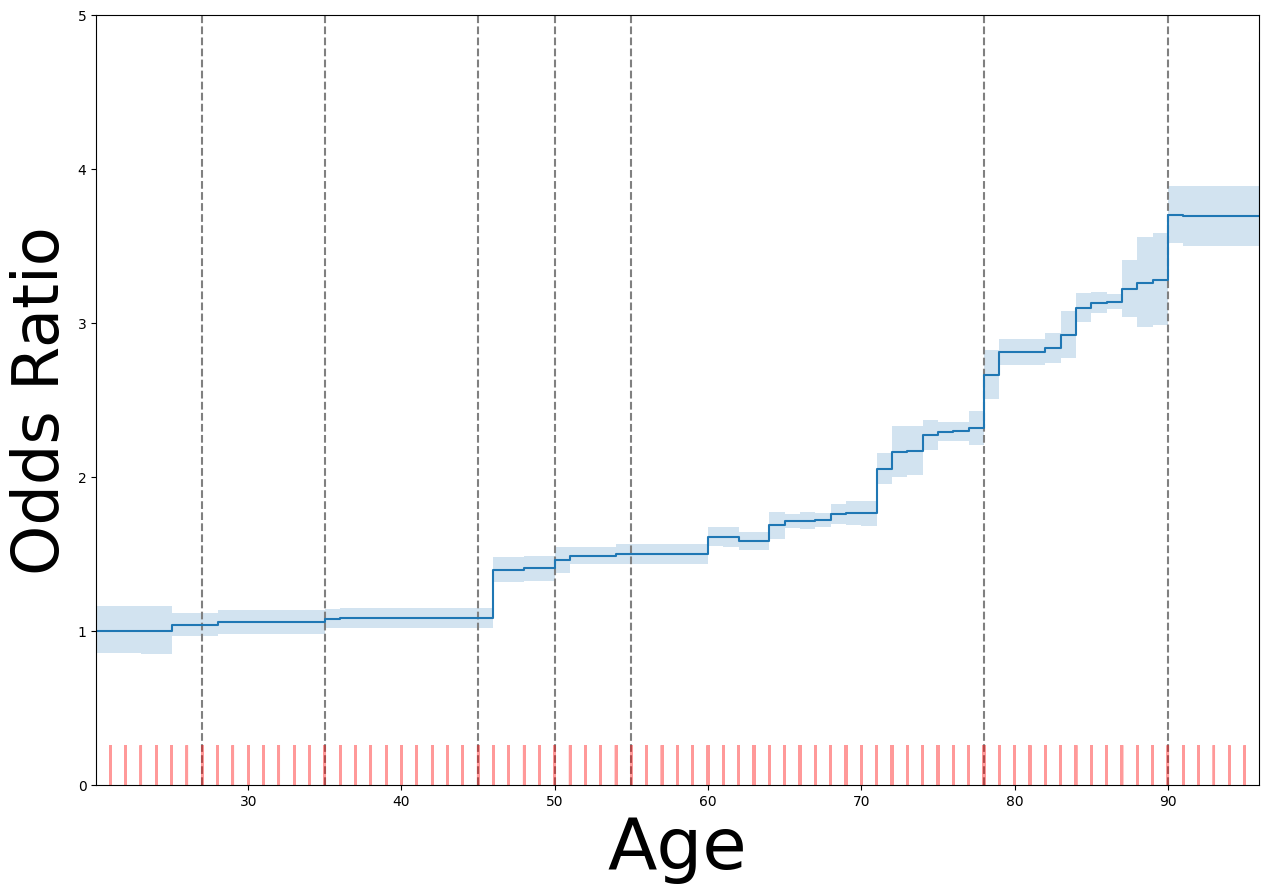

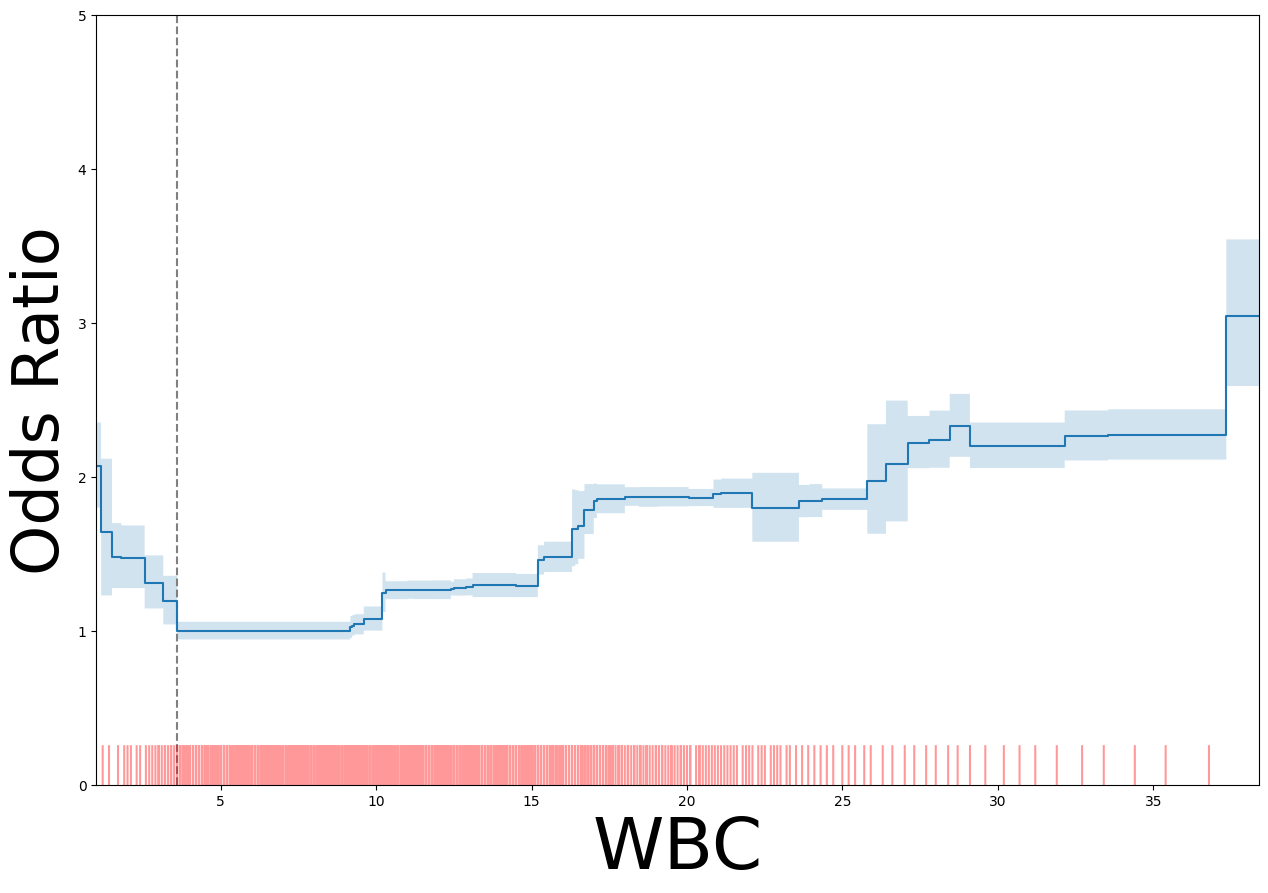

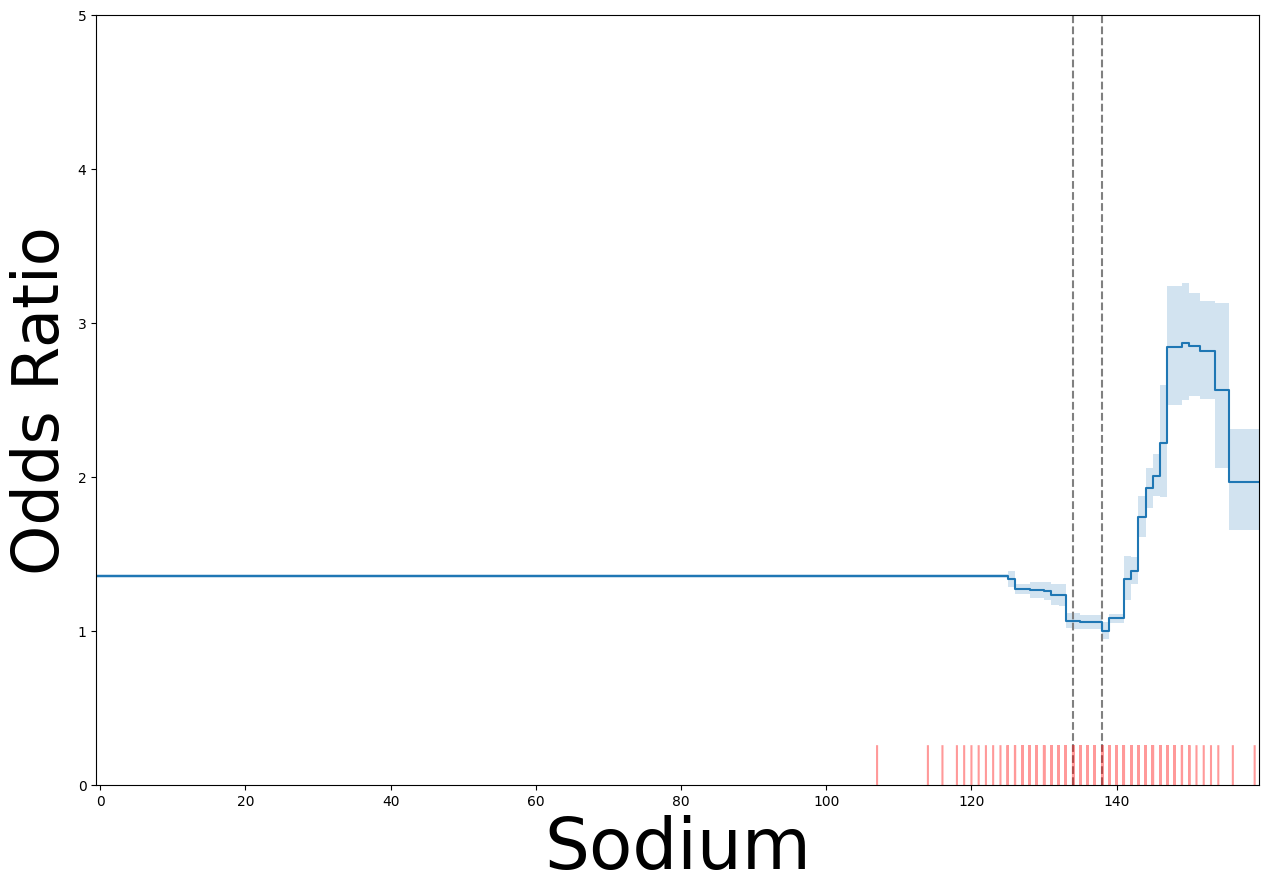

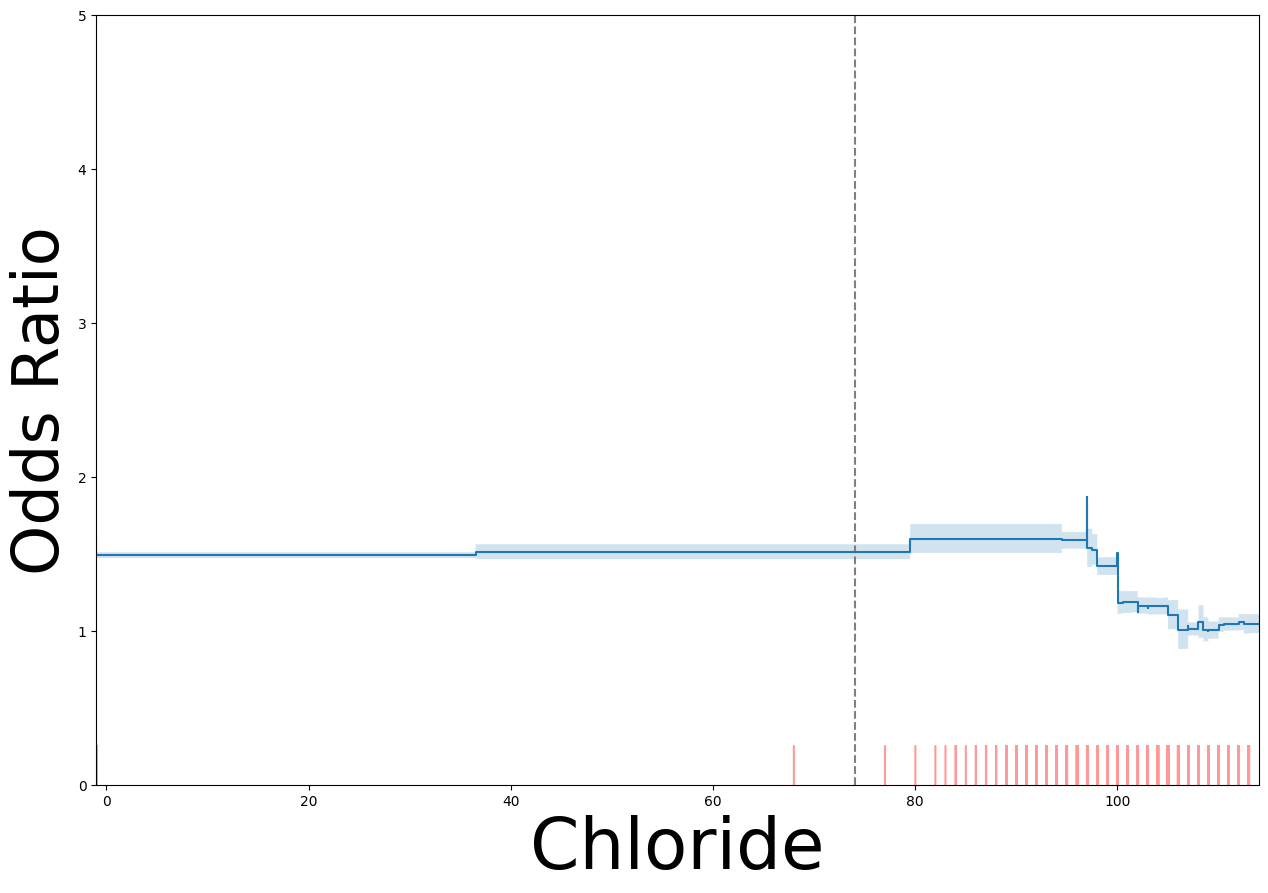

In [8]:
discontinuities = find_and_plot_discontinuities(mimic4_X_sel, mimic4_Y.values,
                                                min_samples=2000,
                                                min_effect_size=1.1)
discontinuities

In [9]:
discontinuities.shape

(27, 5)

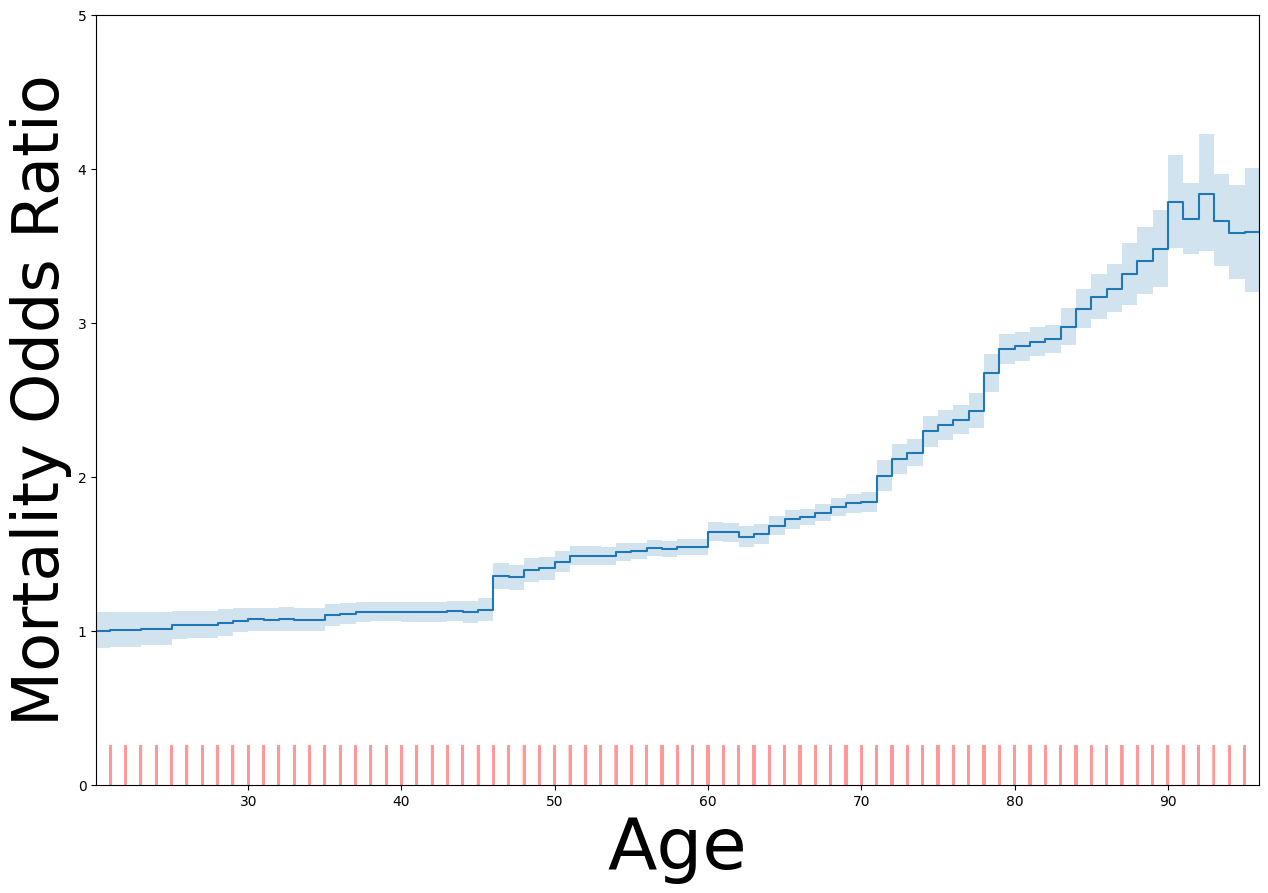

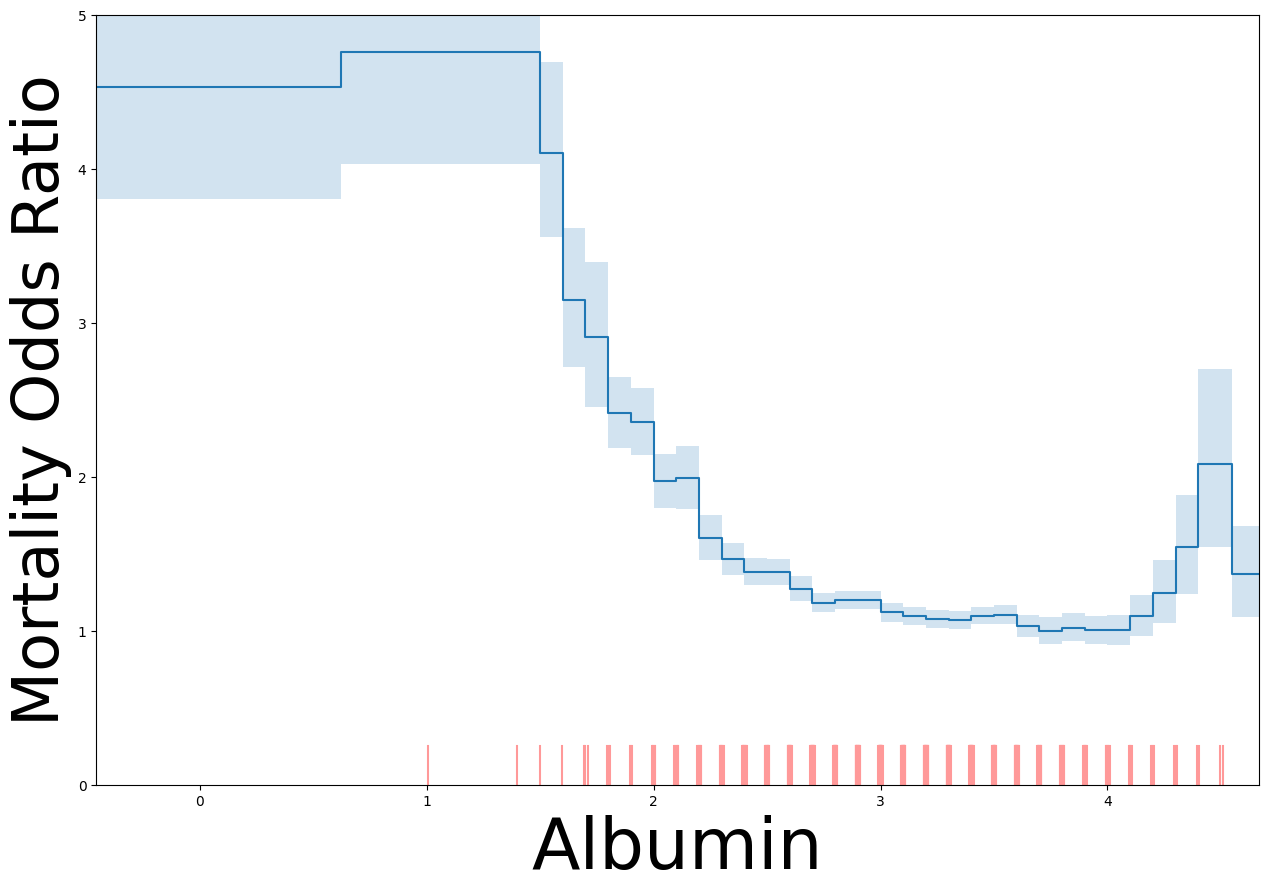

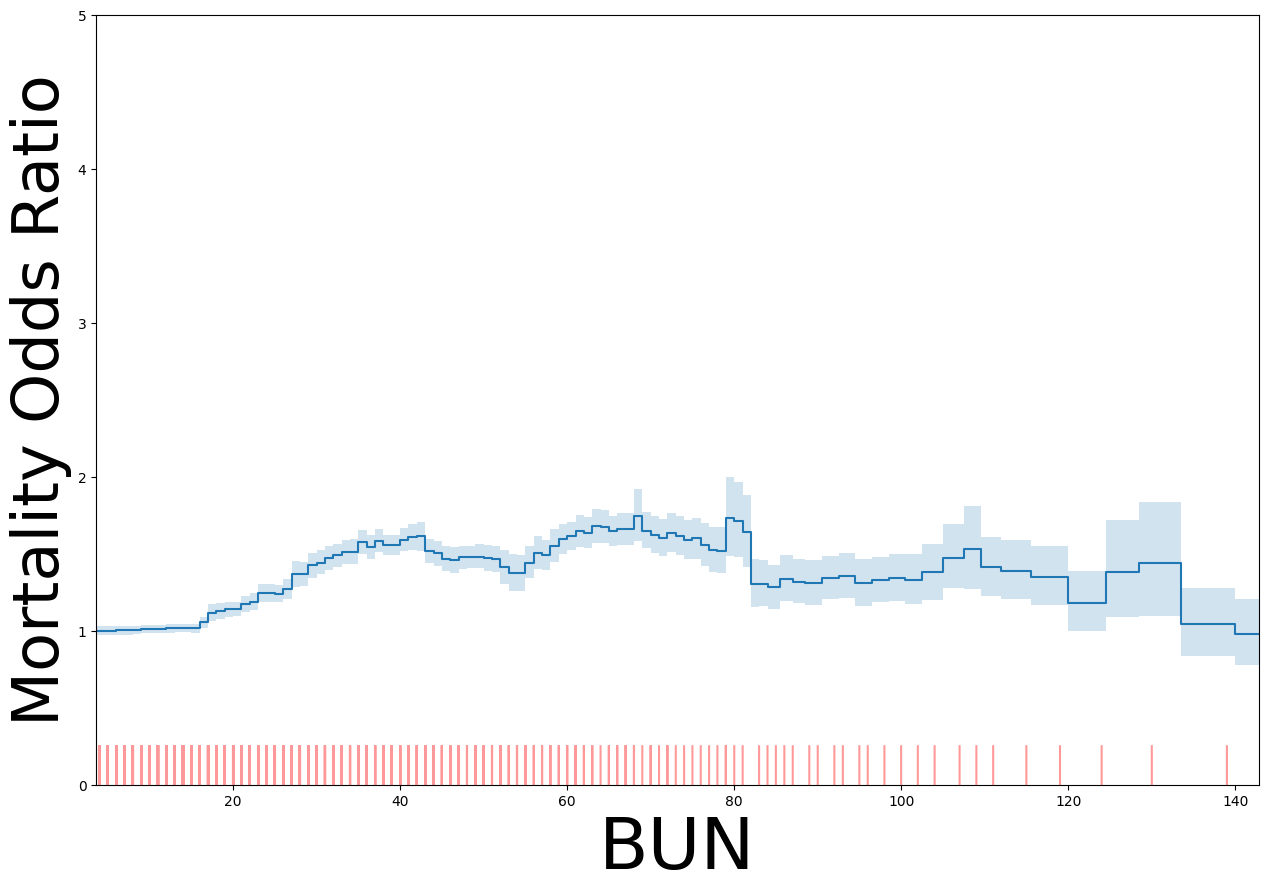

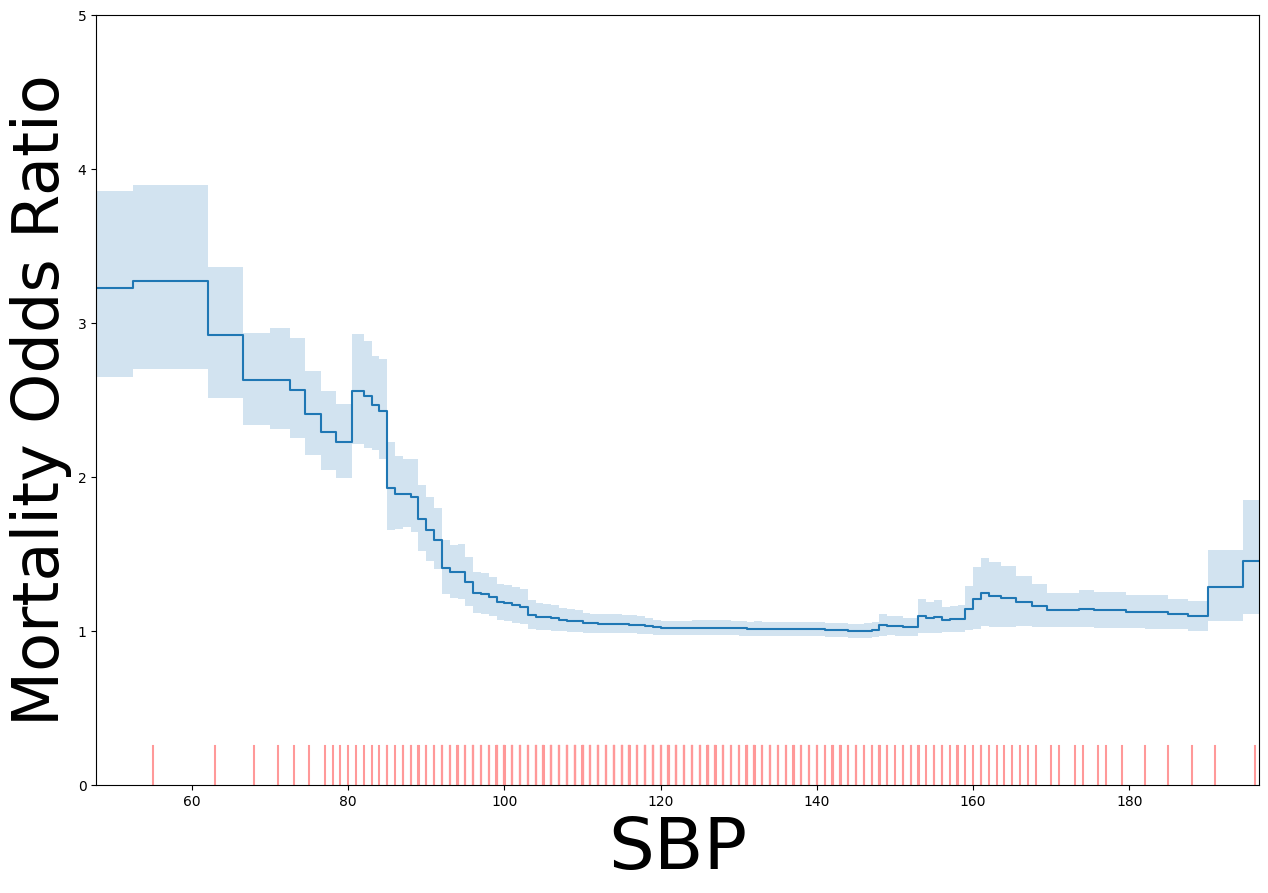

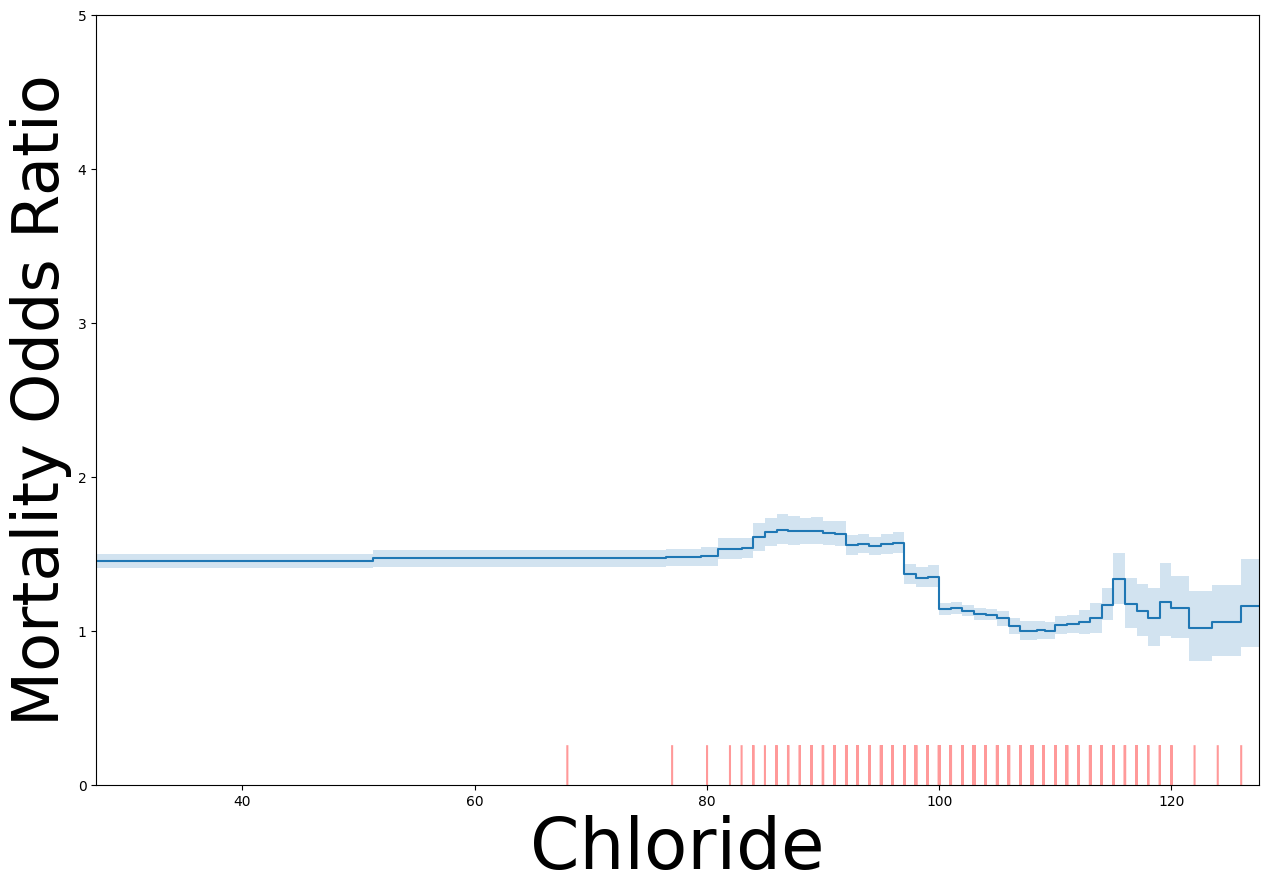

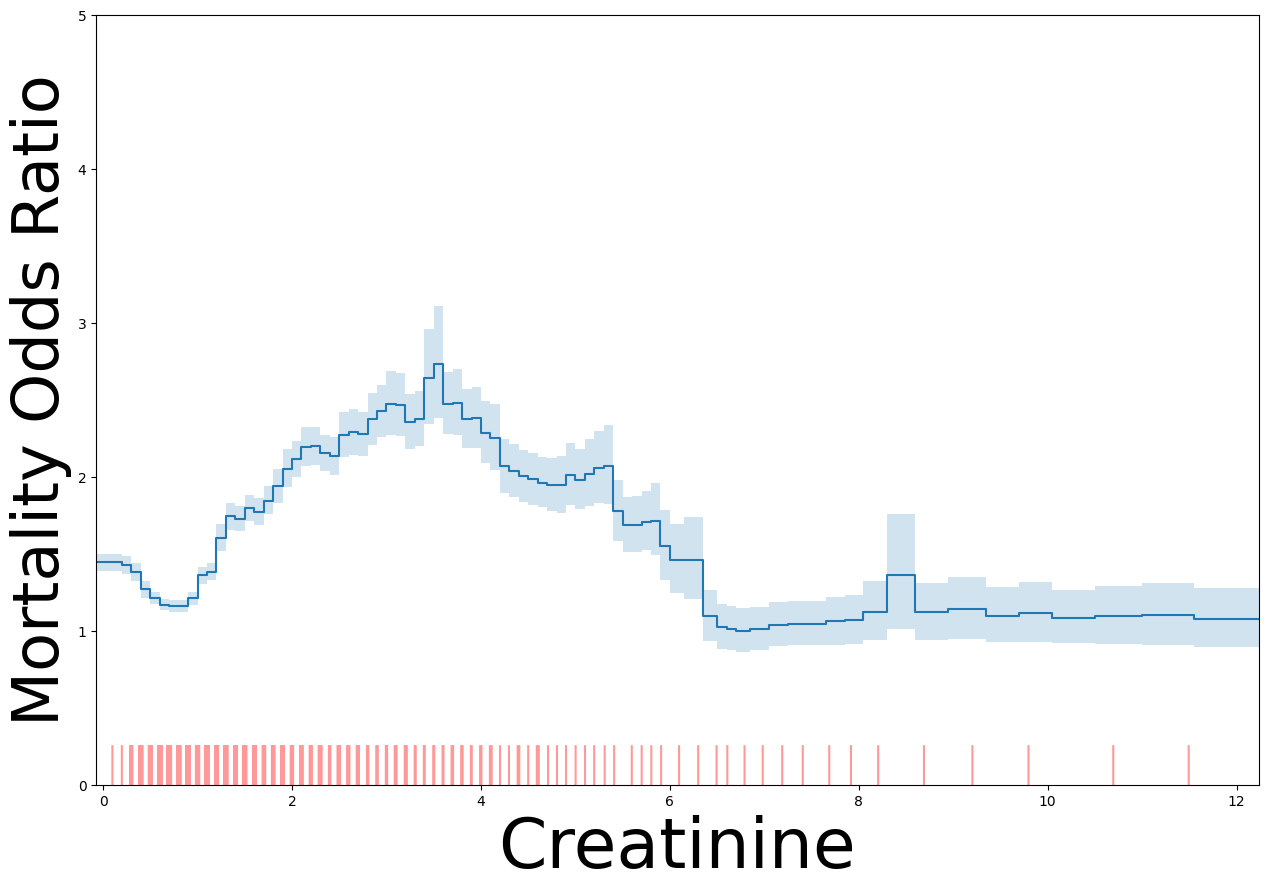

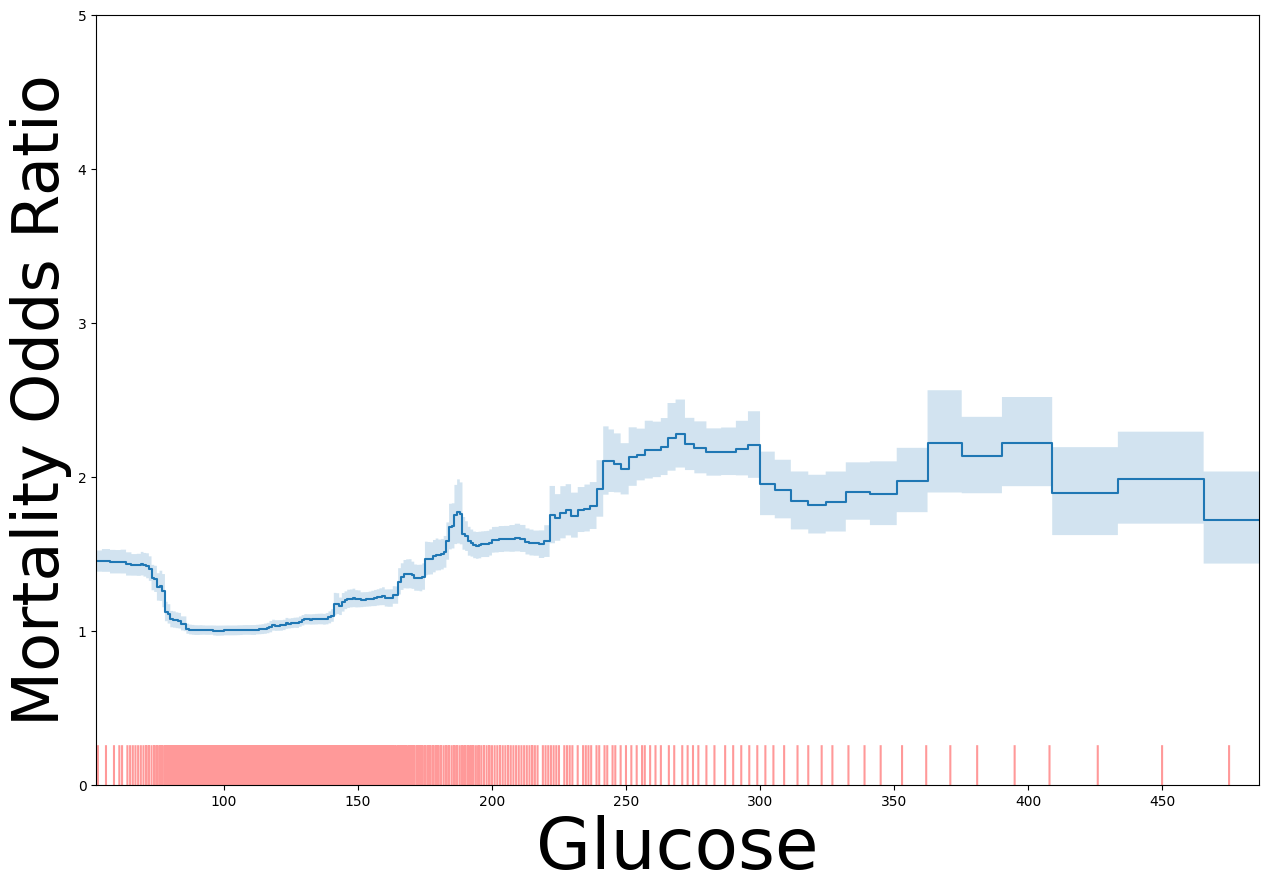

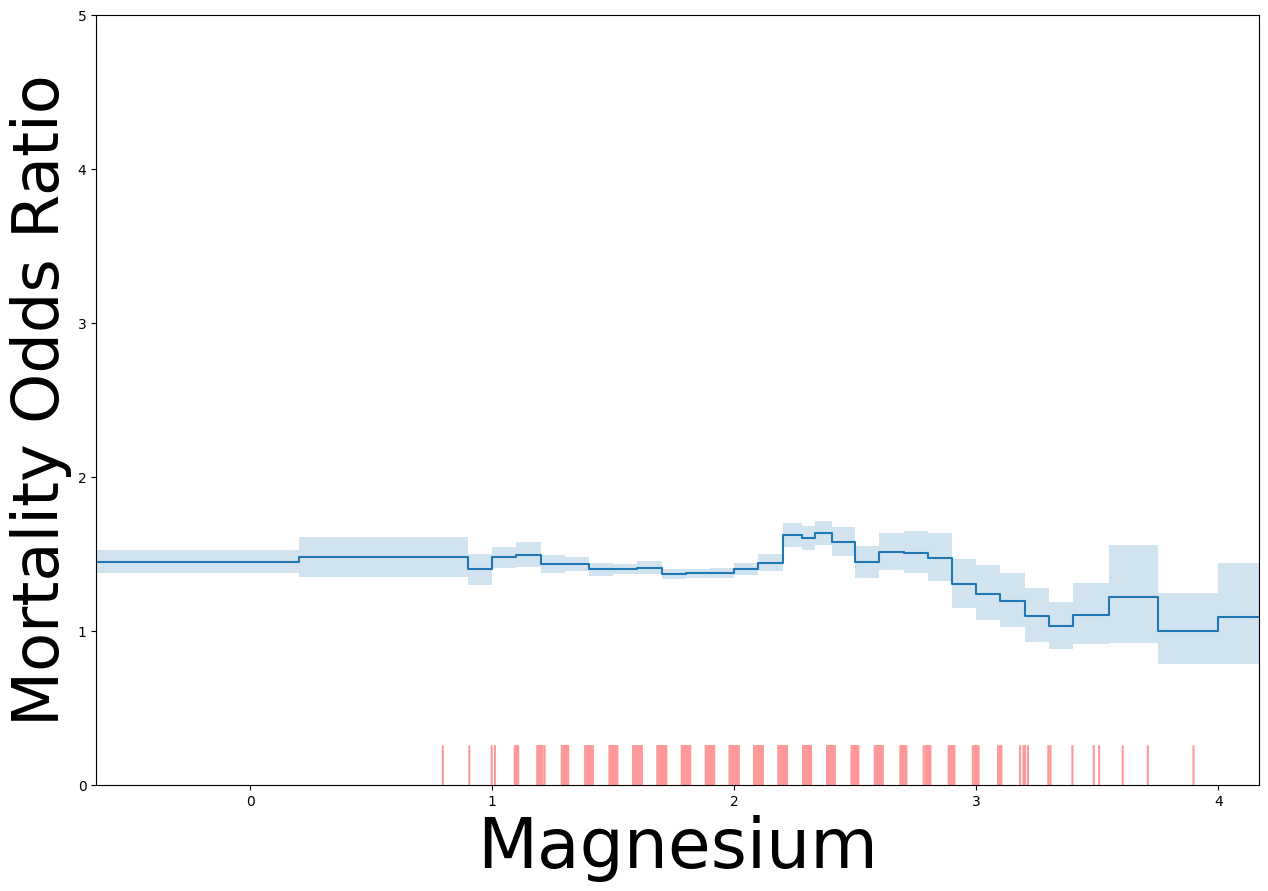

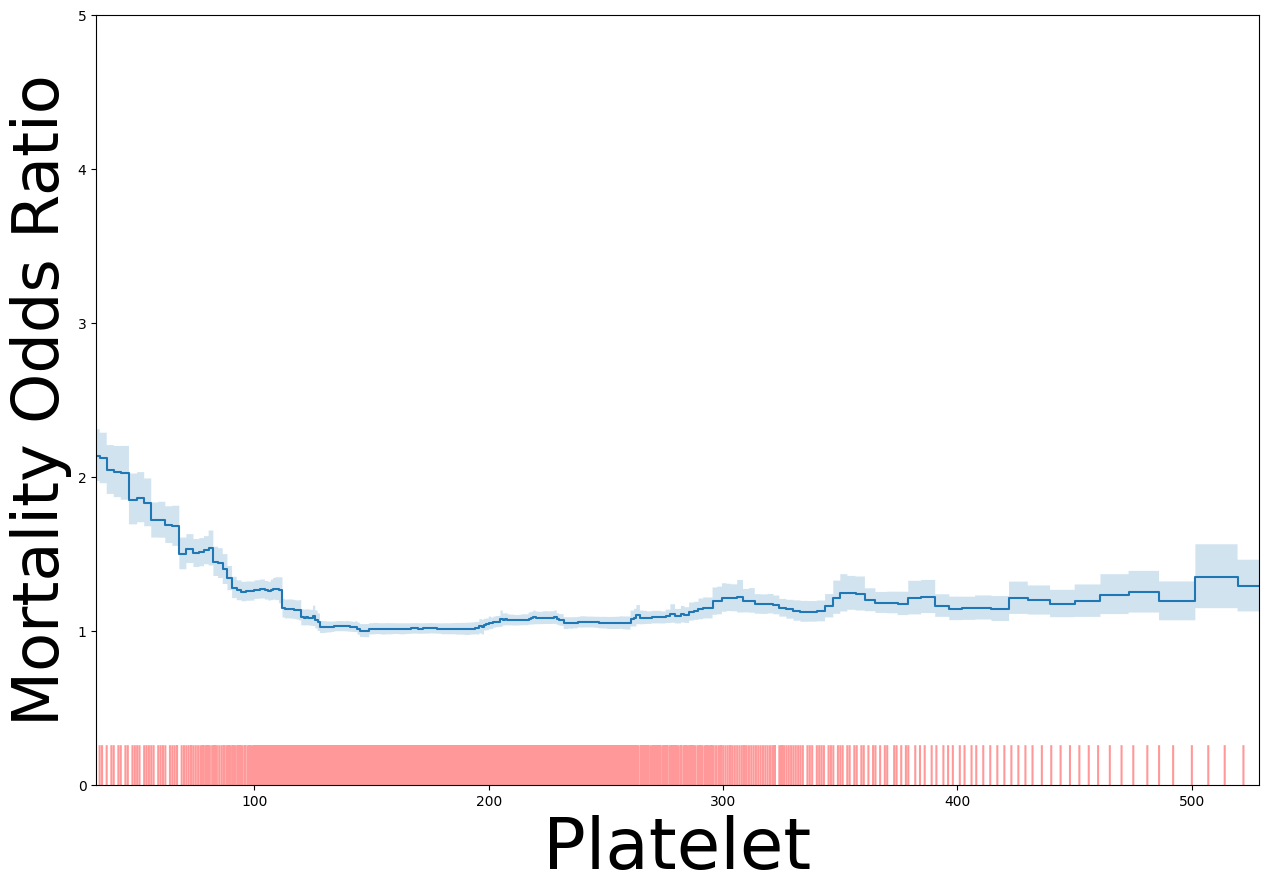

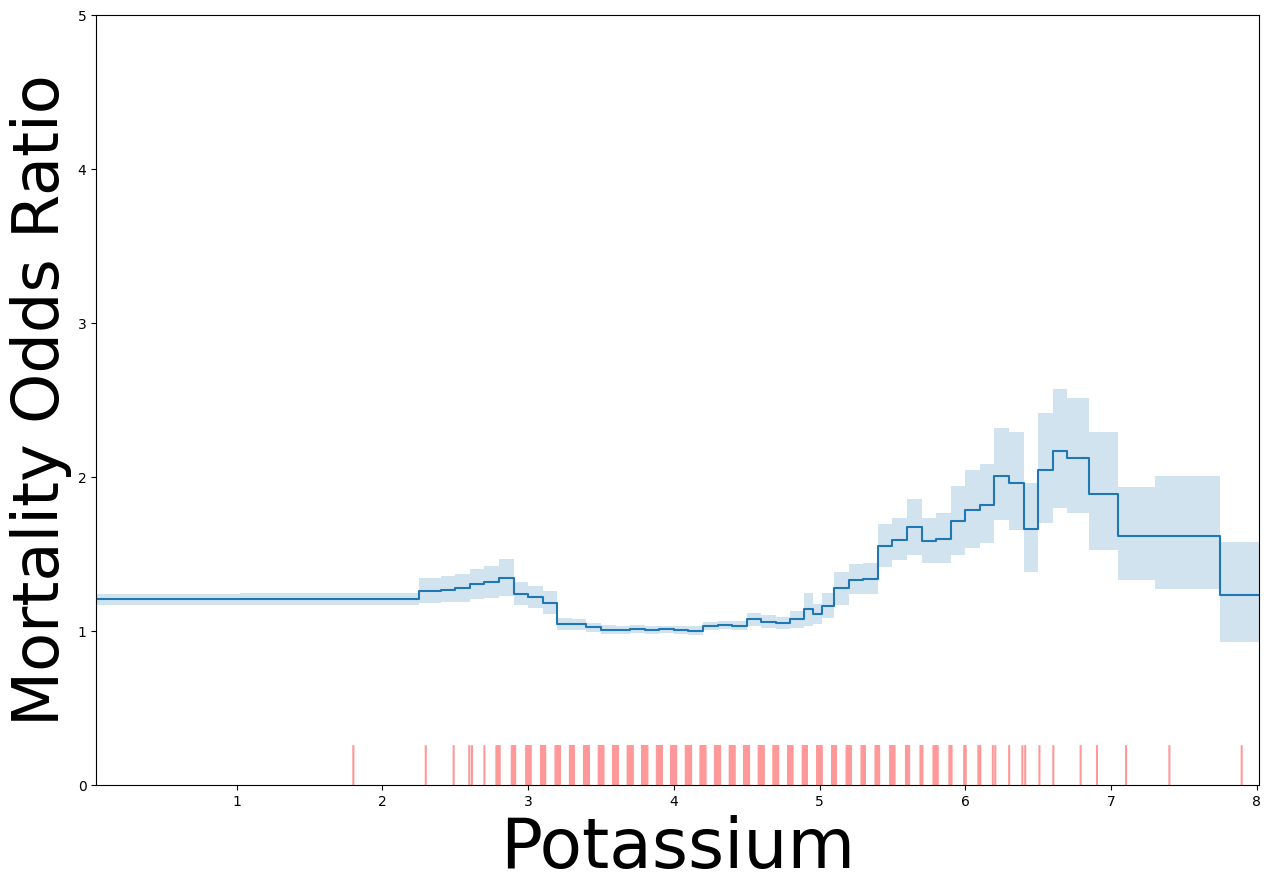

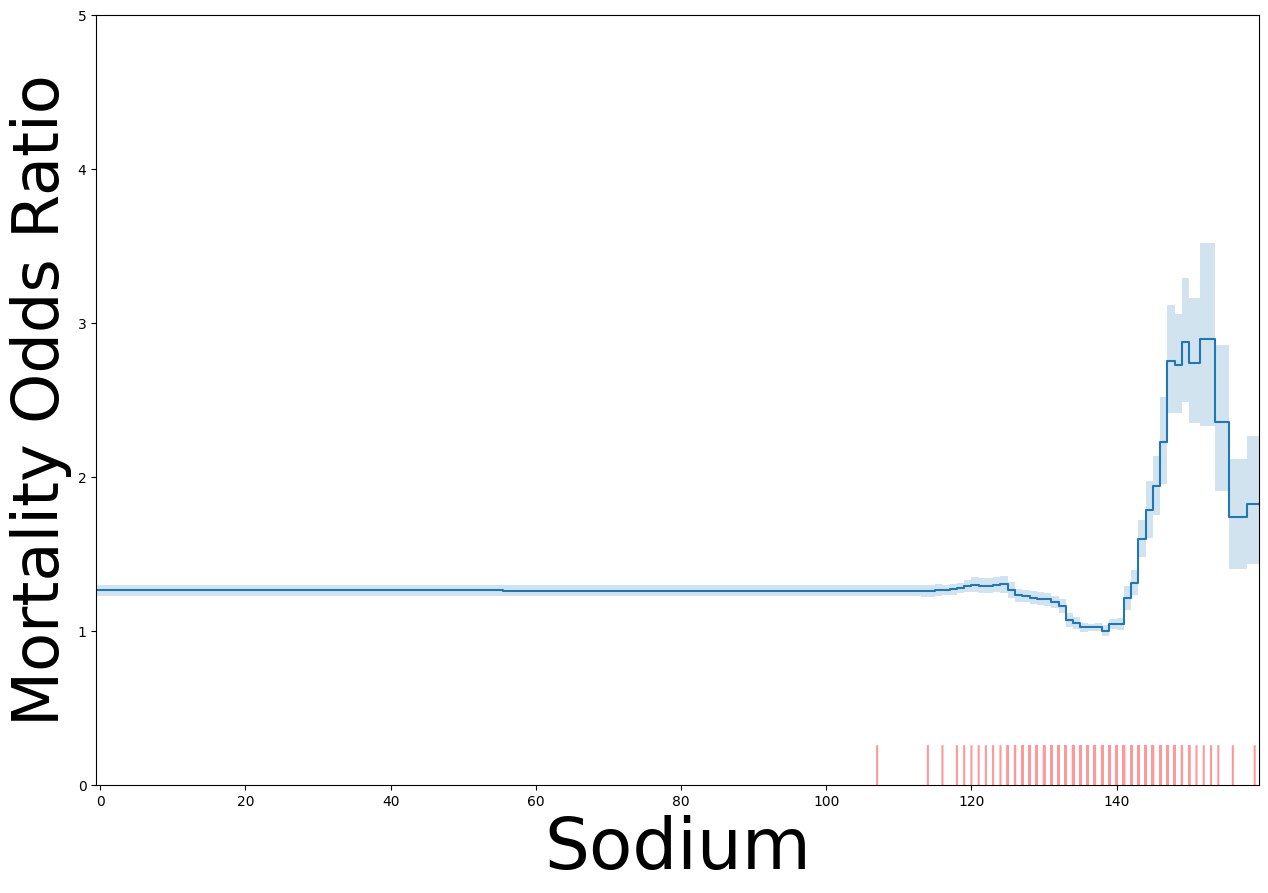

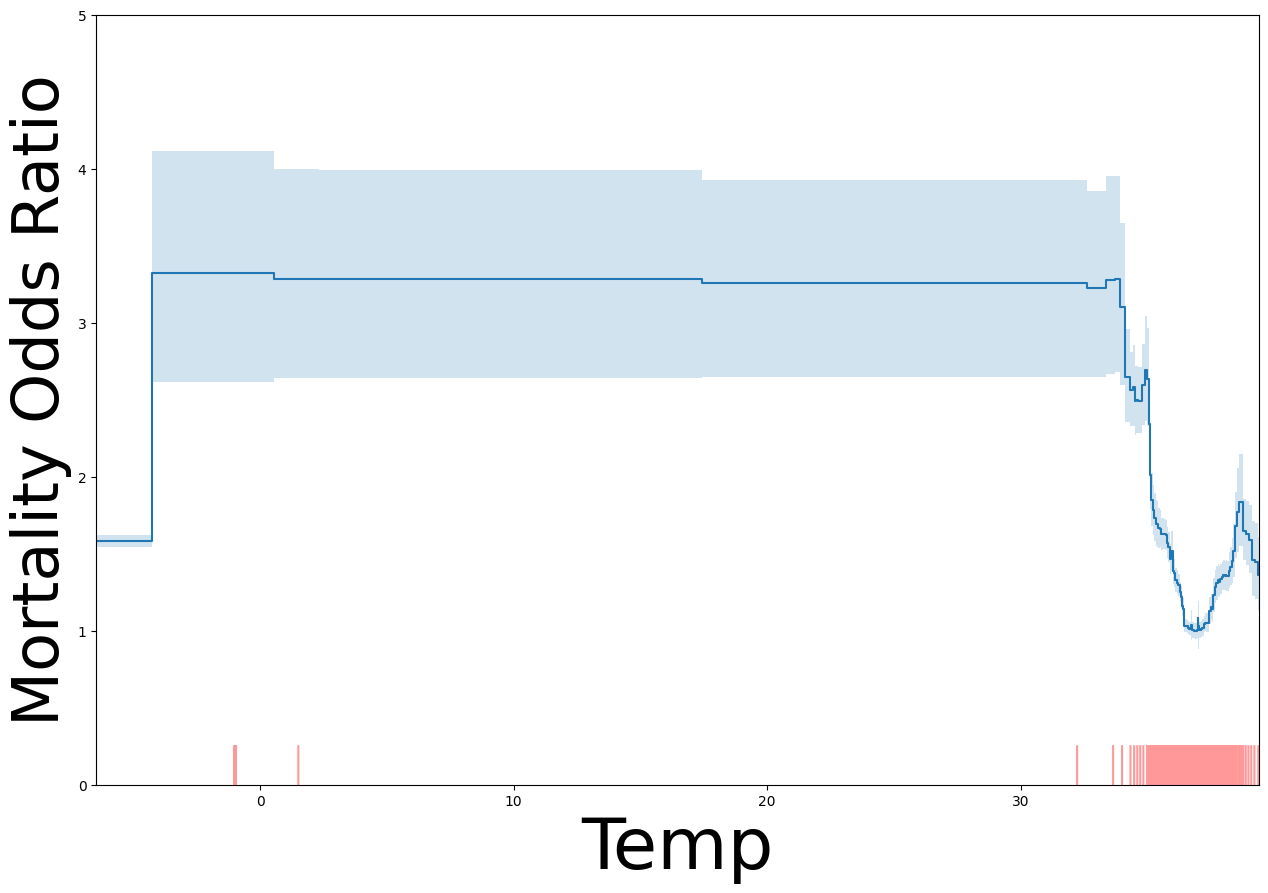

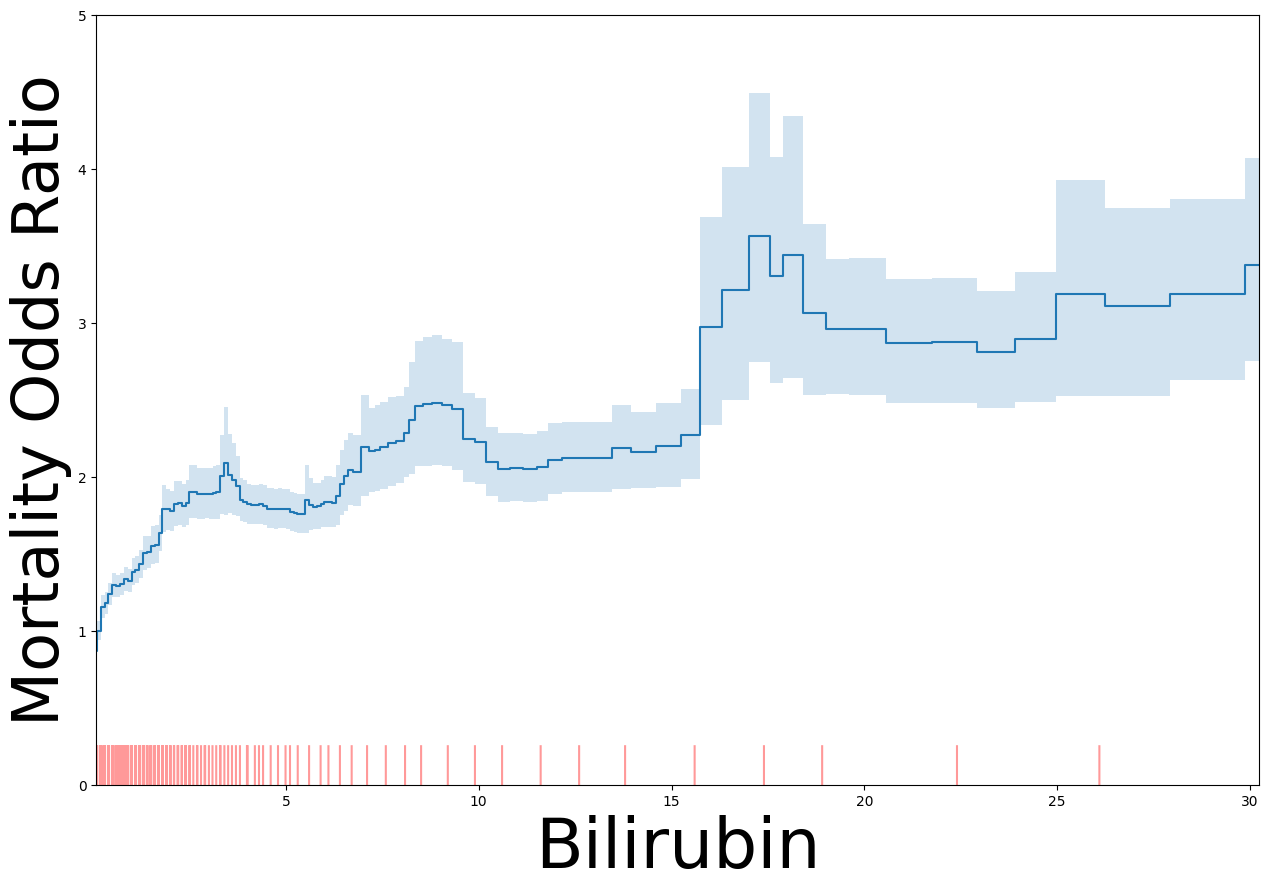

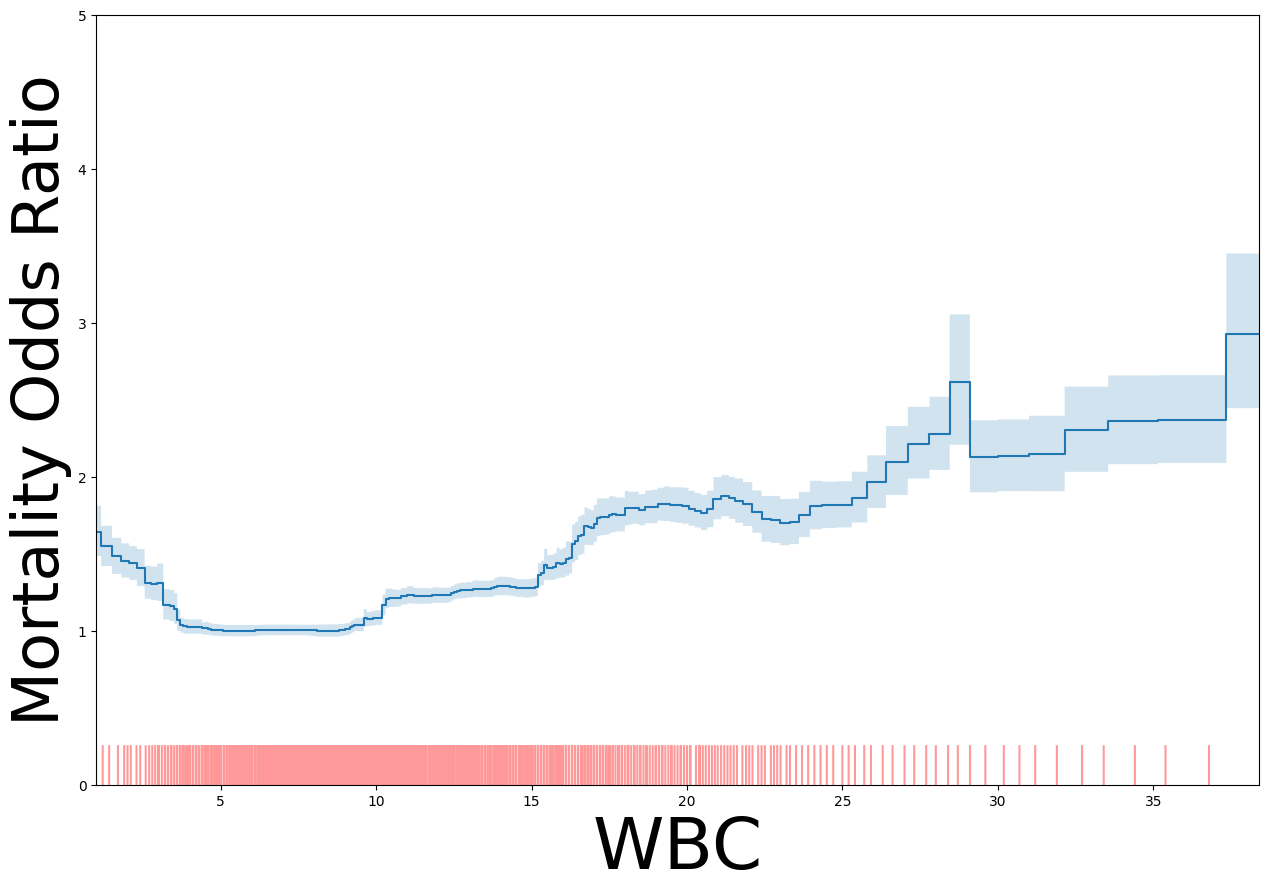

In [10]:
import ebm_utils
# Helper functions for pretty plotting available from:
# https://github.com/blengerich/ebm_utils

from ebm_utils.analysis.plot_utils import plot_all_features, plot_importances
from ebm_utils.analysis.purify_utils import purify_and_update
from ebm_utils.analysis.importance import calc_importance

plot_all_features(
    ebm_globals["mimic4"], mimic4_X_sel,
    bool_mpl_style=True, bool_figsize=(12, 12),
    ylabel='Mortality Odds Ratio',
)